In [1]:
# <!-- collapse=True --> 
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark -d -v -u -t -z
%pylab inline
%run steering_setup ;
basedir='/scratch/jet'
###nc = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.007.pop.h.nday1.yr.0249.nc')
###nc = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.007.pop.h.nday1.0249-01.nc')
###nc = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.013.pop.h.nday1.291_310.ncra.nc')
###nc = Dataset(basedir+'/steering/testpop.nc')
filename=basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.018.pop.h.nday1.0249.nc'
regrid_filename=basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.018.regrid.nc'
nc = Dataset(filename)
regrid2rect(filename,regrid_filename,clobber=True)
ncregrid = Dataset(regrid_filename)
omega=7.2921e-5
deg2rad=pi/180
f=2*omega*sin(lat*deg2rad)

Installed watermark.py. To use it, type:
  %load_ext watermark
Last updated: 24/04/2015 13:31:24 MDT

CPython 2.7.9
IPython 3.0.0
Populating the interactive namespace from numpy and matplotlib


#CAM Implementation of Mesoscale eddy diffusivity based on mixing theory

Here are my notes on the development of a parameterization for eddy diffusivity.  The scheme is based on the [paper](http://journals.ametsoc.org/doi/abs/10.1175/JPO-D-13-0130.1) by Michael Bates, Ross Tulloch, John Marshall, and Raffaele Ferrari. I'm working with Gokhan Danabasoglu and Matt Long here at NCAR and John Marshall (co-author) at MIT.

The general approach of this effort will be to follow Gokhan's implementation notes, isolating each of the terms contributing to the eddy diffusivity given by equation 6 in Bates et al. and comparing the CESM implementation of those terms with Bates, reanalysis, or other observations. 

##Gokhan's Implementation Notes on Diffusivity with Steering Level Suppression

12 November 2014

Starting with $$K=u_{rms}∗L_{mix}$$ 

the general form for diffusivity, $K$, is given by equation (6) of [Bates et al. (2014)](<http://journals.ametsoc.org/doi/abs/10.1175/JPO-D-13-0130.1>). Namely,  
  
  $$L_{mix} = {\Gamma * L_{eddy} \over (1 + b1 * |u_{mean} - c|^2 /u_{rms}^2 (z=0)} $$

Here,

  * $u_{rms}$ is the root-mean-square (rms) eddy velocity;

  * $L_{mix}$ is the mixing length;

  * $L_{eddy}$ is the eddy diameter (depth independent);

  * $u_{mean}$ is the mean zonal velocity (resolved);

  * $c$ is the zonal eddy phase speed (depth independent);

  * $\require{cancel} \cancel {\Gamma = 0.35}$;

  * $\Gamma = 1.75$ (Tuning mod: the original Gamma of .35 produced a Kappa with the correct structure but too weak.;

  * $b1 \sim 4$.


###Eddy Length Scales:

Rossby deformation radius = $L_r = {c_r \over |f|}$

Equatorial Rossby deformation radius $= L_{req} = {\sqrt{c_r \over 2\beta}}$

Rhines scale $= L_{Rh} = {\sqrt{u_{rms} \over \beta}} \sim {\sigma_{vi} \over \beta}$

$c_r$ is the first baroclinic wave speed computed following equation (2.2) of Chelton et al. (1998) with $m=1$;

$f$ is the Coriolis parameter; 

$\beta$ is the latitudinal variation of the Coriolis parameter; and 

$\sigma_{vi}$ is the Eady growth rate given by

$\sigma_{vi} = {f \over \sqrt{R_i}}$

with $R_i$ the vertically integrated (over the 100 – 2000 m depth range) Richardson number.



So, any one these length scales could be used as an eddy length scale. An alternative is

$L_{eddy} = min (L_r, L_{req}, L_{Rh}).$

###Eddy Velocity:

$\cancel {u_{rms} = alpha*\sigma_{vi}*L_r}$

$u_{rms} = max(5.,alpha*\sigma_{vi}*L_r)$ (Tuning mod: U_rms minimum put in place to tune to surface obs of Bates.) 

where $\sigma_{vi}$ is the Eady growth rate based on local Richardson number and $\alpha$ is a scaling constant.

###Zonal phase speed:

$c = - \beta * L_r^2$  
  
###References:

Bates, M., R. Tulloch, J. Marshall, and R. Ferrari, 2014: Rationalizing the spatial distribution
of mesoscale eddy diffusivity in terms of mixing length theory. J. Phys. Oceanogr., 44,
1523-1540, doi: 10.1175/JPO-D-13-0130.1.

Chelton, D. B., R. A. deSzoeke, M. G. Schlax, K. E. Naggar, and N. Siwertz, 1998: Geographical
variability of the first baroclinic Rossby radius of deformation. J. Phys. Oceanogr., 28,
433-460.

Tullock, R., J. Marshall, and K. S. Smith, 2009: Interpretation of the propagation of surface
altimetric observations in terms of planetary waves and geostropic turbulence. J.
Geophys. Res., 114, C02005, doi: 10.1029/2008JC005055.

###Questions:

  1. In the 2D implementation, $u_{rms}$ and $u_{mean}$ specifications: upper-ocean vertically or integrated or at $z = 0$?
  
        A: $U_{rms}$ is not depth dependent; both $u_{rms}$ and $u_{mean}$ are for surface only
        
  3.  In the 2D implementation, vertical profile will be specified by $N2(z)$?
  
        A: Yes, $N^2(z) \over N_{ref}(z)$ to be more precise
        
  4.   Local $R_i$ use imbedded in sigma in $u_{rms}$ calculation?
  
        A: No, $u_{rms}$ is depth independent
        
  5.   alpha = ?
  
        A: trial and error
        
  6. Cancellation of $f$’s in $u_{rms}$ calculation?

  7. Zonal phase speed equation correct? Both $\beta$ and $L_r$ will be positive, producing $c < 0$ always. This appears to be in contrast with Tullock et al. (2009).

        A: What is plotted in Bates is (U-c)


###Parameterizing the Eddy Length Scale $\quad \color{red}{L_{eddy}}$


$$K=u_{rms}∗{\Gamma * \color{red}{L_{eddy}} \over (1 + b1 * |u_{mean} - c|^2 /u_{rms}^2 (z=0)} $$  


The three length scales under consideration:  

   1. Rossby Deformation Radius $\quad\quad L_r = {c_r \over |f|}$
   2. Rossby Equatorial Radius $ \quad\quad= L_{req} = {\sqrt{c_r \over 2\beta}}$
   3. Rhine's Scale $ \quad\quad L_{Rh} = {\sqrt{u_{rms} \over \beta}} \sim {\sigma_{vi} \over \beta}$

The Rossby Deformation Radius $L_r$ depends on the the Baroclinic wave speed $c_r$ and the Coriolis force $f$.  The CESM value of the first Baroclinic wave speed is derived as per eq 2.2 in [Chelton 1998](http://journals.ametsoc.org/doi/full/10.1175/1520-0485%281998%29028%3C0433%3AGVOTFB%3E2.0.CO%3B2).



### First Baroclinic Wave Speed $c_r$ Chelton vs CESM 

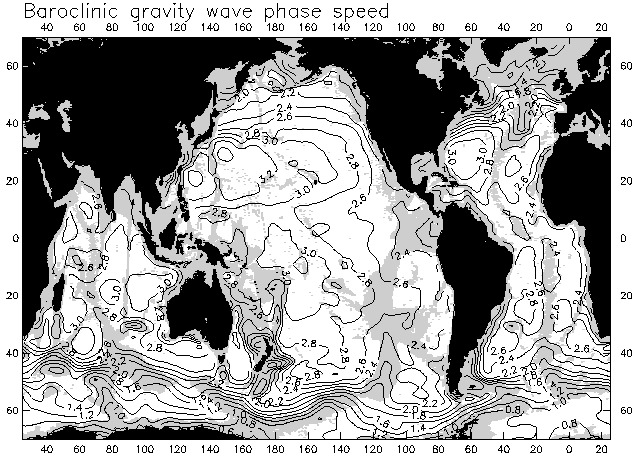

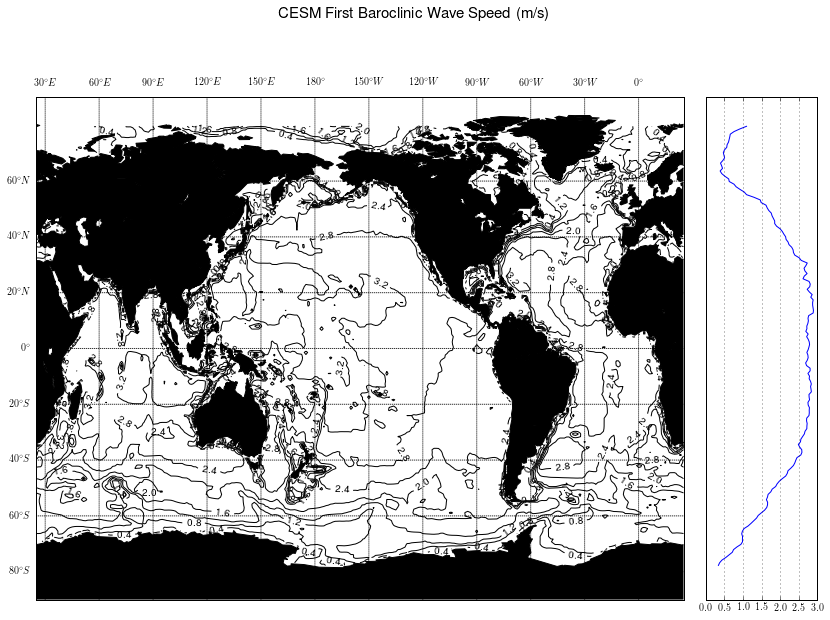

In [2]:
# <!-- collapse=True --> 
### get Variable from file c_rossby is in cm/s convert to m/s
c_rossby = nc.variables['C_ROSSBY'][0,:,:]


#Resample (aka re-project, re-grid) the NCEP data to target grid. First with nearest neighbour resampling...
c_rossby_nearest = pyresample.kd_tree.resample_nearest(orig_def, c_rossby, \
        targ_def25, radius_of_influence=500000, fill_value=None)
c_rossby_mps = c_rossby_nearest/100.

fig1=MapZoneContour(targ_def25.lons,targ_def25.lats,c_rossby_mps,figsize=(14,9),
                    title="CESM First Baroclinic Wave Speed (m/s)",
                    llcrnrlon=25.,
                    fmt='%.1f' )
c_r_chelton=Image(filename=basedir+'/steering/chelton_sfig1.jpg')
display(c_r_chelton)

### First Baroclinic Rossby Radius Chelton vs CESM 

### CESM Rossby deformation radius = $L_{eddy}$
$L_r = {c_r \over |f|}$

$L_{req} = {\sqrt{c_r \over 2\beta}}$

$\require{cancel} \cancel {L_{Rh} = {\sqrt{u_{rms} \over \beta}} \sim {\sigma \over \beta}}$

$L_{eddy} = min (L_r, L_{req}, \cancel{L_{Rh}}).$

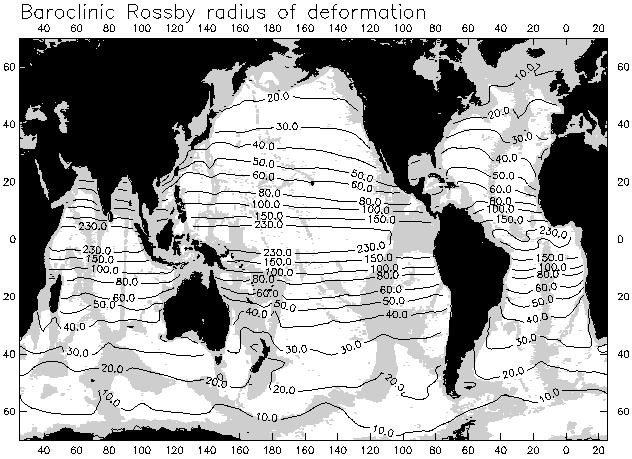

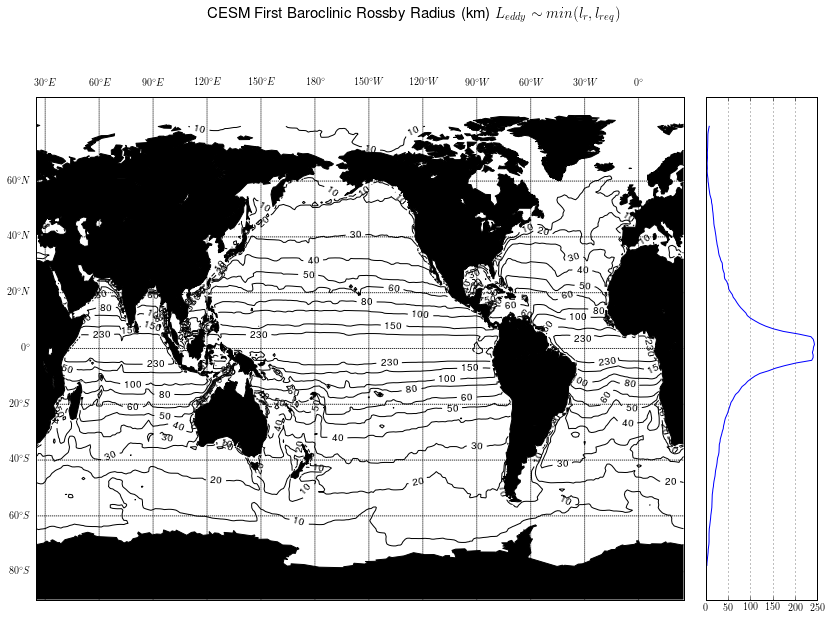

In [3]:
# <!-- collapse=True --> 

fcor = nc.variables['FCOR'][0,:,:]
fcor_nearest = pyresample.kd_tree.resample_nearest(orig_def, fcor, \
        targ_def25, radius_of_influence=500000, fill_value=None)
absf=np.abs(fcor_nearest)
l_rossby_calc=c_rossby_nearest/absf

btp = nc.variables['BTP'][0,:,:]
btp_nearest = pyresample.kd_tree.resample_nearest(orig_def, btp, \
        targ_def25, radius_of_influence=500000, fill_value=None)

l_rossbyeq_calc=np.sqrt(c_rossby_nearest/(2*btp_nearest))
l_eddy_calc=np.minimum(l_rossby_calc,l_rossbyeq_calc)

### convert regridded radius from cm to km
cm2km=1.e-5
l_eddy_calc_km=l_eddy_calc*cm2km
clevs=[10,20,30,40,50,60,80,100,150,230]
fig2=MapZoneContour(targ_def25.lons,targ_def25.lats,l_eddy_calc_km,figsize=(14,9),
                    levels=clevs,
                    llcrnrlon=25.,
                    title="CESM First Baroclinic Rossby Radius (km) $L_{eddy} \sim min(l_r,l_{req})$",
                    fmt='%.1i' )

lrhines = nc.variables['L_RHINES'][0,:,:]
lrhines_nearest = pyresample.kd_tree.resample_nearest(orig_def, lrhines, \
        targ_def25, radius_of_influence=500000, fill_value=None)

###clevs=np.logspace(1,15,40)
###norm=LogNorm()
###fig,ax,cbar =MapContourg(targ_def0,lrhines_nearest,
###                    addzonal=True,
###                    levels1=clevs,
###                    norm=norm,
###                    figsize=(14,5),
###                    title="$L_{rhines} (cmn^2)$ log scale")
###cbar.set_ticks(np.logspace(1,15,15))
if False:
    l_eddy1=np.maximum(l_eddy_calc,lrhines_nearest)
    l_eddy1_km=l_eddy1*cm2km
    clevs=[10,20,30,40,50,60,80,100,150,230]
    fig2=MapZoneContour(targ_def25.lons,targ_def25.lats,l_eddy1_km,figsize=(14,9),
                    levels=clevs,
                    llcrnrlon=25.,
                    title="CESM First Baroclinic Rossby Radius (km) using rhines scale $L_{eddy} \sim max(l_rhines,min(l_r,l_{req}))$",
                    fmt='%.1i' )

l_r_chelton=Image(filename=basedir+'/steering/chelton_fig2.jpg')
display(l_r_chelton)

In [4]:
# <!-- collapse=True --> 
# recalculate these based on maps which start at 0 longitude
c_rossby_nearest = pyresample.kd_tree.resample_nearest(orig_def, c_rossby, \
        targ_def0, radius_of_influence=500000, fill_value=None)
c_rossby_mps = c_rossby_nearest/100.
fcor = nc.variables['FCOR'][0,:,:]
fcor_nearest = pyresample.kd_tree.resample_nearest(orig_def, fcor, \
        targ_def0, radius_of_influence=500000, fill_value=None)
absf=np.abs(fcor_nearest)
l_rossby_calc=c_rossby_nearest/absf

btp = nc.variables['BTP'][0,:,:]
btp_nearest = pyresample.kd_tree.resample_nearest(orig_def, btp, \
        targ_def0, radius_of_influence=500000, fill_value=None)

l_rossbyeq_calc=np.sqrt(c_rossby_nearest/(2*btp_nearest))
l_eddy_calc=np.minimum(l_rossby_calc,l_rossbyeq_calc)
cm2km=1.e-5
l_eddy_calc_km=l_eddy_calc*cm2km


lrhines = nc.variables['L_RHINES'][0,:,:]
lrhines_nearest = pyresample.kd_tree.resample_nearest(orig_def, lrhines, \
        targ_def0, radius_of_influence=500000, fill_value=None)
l_eddy1=np.maximum(l_eddy_calc,lrhines_nearest)
l_eddy1_km=l_eddy1*cm2km


###Parameterizing Zonal Eddy Phase Speed $\color{red}{c}$


$K=u_{rms}∗{\Gamma * L_{eddy} \over (1 + b1 * |u_{mean} - \color{red}{c}|^2 /u_{rms}^2 (z=0)} $

$\cancel{c = - \beta * {L_r^2}}$       $L_r$ too high at equator 

$c = - \beta * L_{eddy}^2$


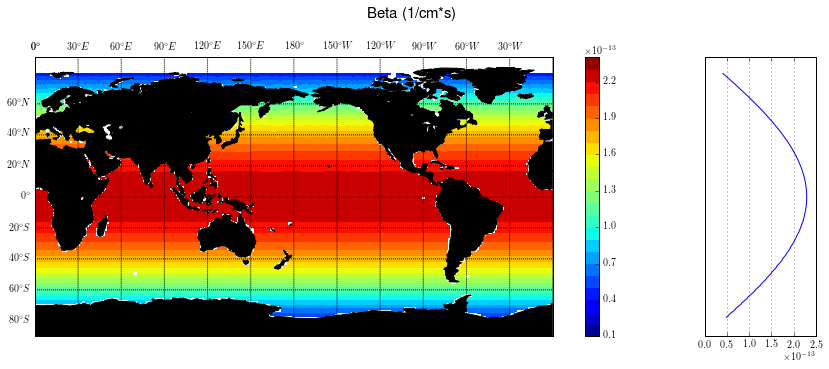

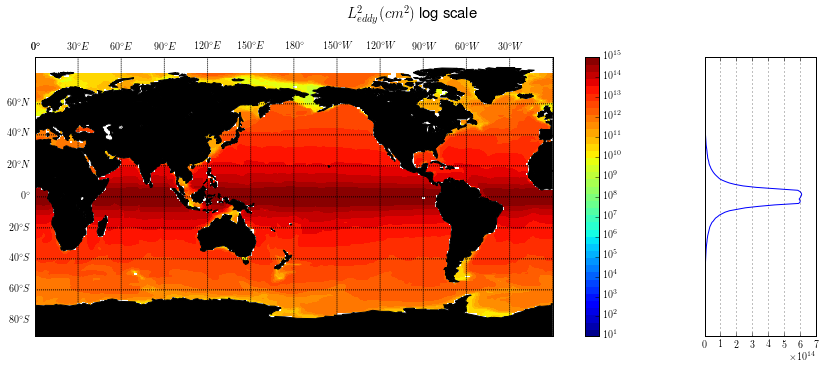

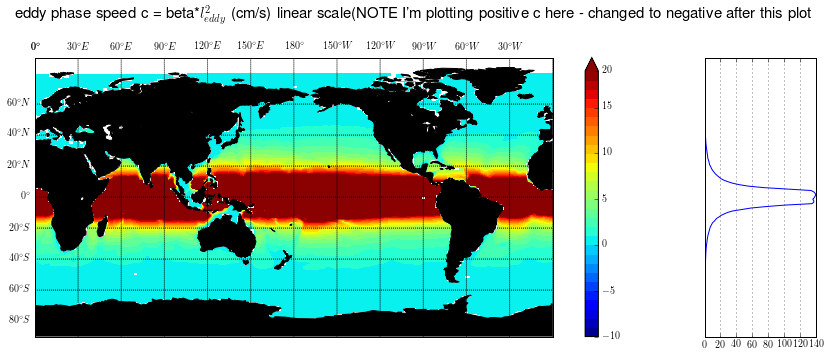

In [5]:
# <!-- collapse=True --> 
#beta
clevs=arange(1.e-14,25.e-14,1e-14)
fig,ax,cbar =MapContourg(targ_def0,btp_nearest,
                    levels1=clevs,
#                    norm=norm,
                    addzonal=True,
                    figsize=(14,5),
                    title="Beta (1/cm*s)")
l_eddy_calc_sq=l_eddy_calc*l_eddy_calc
clevs=np.logspace(1,15,40)
norm=LogNorm()
fig,ax,cbar =MapContourg(targ_def0,l_eddy_calc_sq,
                    addzonal=True,
                    levels1=clevs,
                    norm=norm,
                    figsize=(14,5),
                    title="$L_{eddy}^2 (cm^2)$ log scale")
#cbar.ax.get_xaxis().get_major_formatter().labelOnlyBase = True
#cbar.ax.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=True))
#ax.yaxis.set_major_locator(ticker.MultipleLocator)
#ax.yaxis.set_major_formatter(LogFormatter())
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()
cbar.set_ticks(np.logspace(1,15,15))

c=btp_nearest*l_eddy_calc*l_eddy_calc # units=1/(cm s) * cm^2 = cm/s


clevs=arange(-10,20,1)
fig,ax,cbar = MapContourg(targ_def0,c,
                    addzonal=True,
                    levels1=clevs,
#                    norm=norm,
                    setover='darkred',
                    figsize=(14,5),
                    title="eddy phase speed c = beta*$l_{eddy}^2$ (cm/s) linear scale(NOTE I'm plotting positive c here - changed to negative after this plot")
cbar.set_ticks(np.linspace(-10,20,7))

if False:
    c_rhines=btp_nearest*l_eddy1*l_eddy1 
    clevs=arange(-10,20,1)
    fig,ax,cbar = MapContourg(targ_def0,c_rhines,
                    addzonal=True,
                    levels1=clevs,
#                    norm=norm,
                    setover='darkred',
                    figsize=(14,5),
                    title="eddy phase speed including rhines scale c = beta*$l_{eddy}^2$ (cm/s) linear scale(NOTE I'm plotting positive c here - changed to negative after this plot")
    cbar.set_ticks(np.linspace(-10,20,7))

c=-1.*c


###Here is the new c_eddy field ( Using $c = max(- \beta * L_r^2,-20)$  )


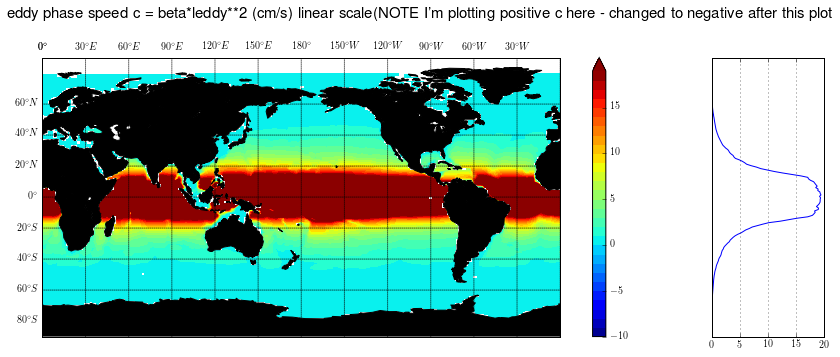

In [6]:
# <!-- collapse=True --> 
ceddy2 = nc.variables['C_EDDYLIM'][0,:,:]
ceddy2_nearest = pyresample.kd_tree.resample_nearest(orig_def, ceddy2, \
        targ_def0, radius_of_influence=500000, fill_value=None)

###c=btp_nearest*l_eddy_calc*l_eddy_calc # units=1/(cm s) * cm^2 = cm/s


clevs=arange(-10,20,1)
fig,ax,cbar = MapContourg(targ_def0,-1*ceddy2_nearest,
                    addzonal=True,
                    levels1=clevs,
#                    norm=norm,
                    setover='darkred',
                    figsize=(14,5),
                    title="eddy phase speed c = beta*leddy**2 (cm/s) linear scale(NOTE I'm plotting positive c here - changed to negative after this plot")
cbar.set_ticks(np.linspace(-10,20,7))

###Hughes Phase Speed (cm/s) from Tulloch Marshall Smith '09

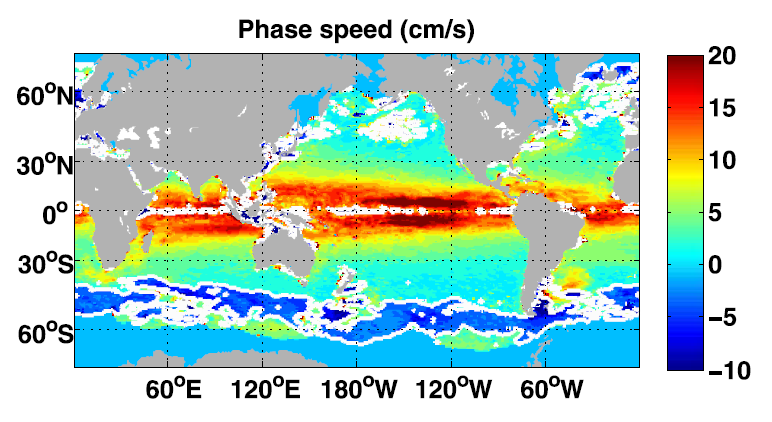

In [7]:
# <!-- collapse=True --> 
hughes_c=Image(filename=basedir+'/steering/Hughes_phase_speed.png')
display(hughes_c)


###Parameterizing the Zonal Velocity $\color{red}{u_{mean}}$


$K=u_{rms}∗{\Gamma * L_{eddy} \over (1 + b1 * |\color{red}{u_{mean}} - c|^2 /u_{rms}^2 (z=0))} $


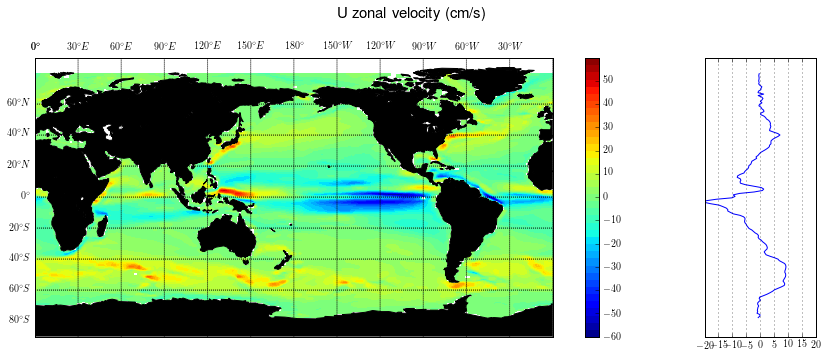

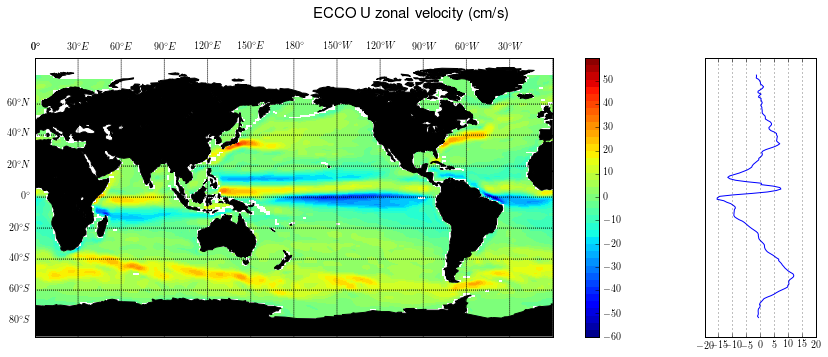

In [8]:
# <!-- collapse=True --> 
#################  PLOT (u-c)^2  convert m^2/s^2 #######################
umean=nc.variables['U_MEAN'][0,:,:]
umean10_nearest = pyresample.kd_tree.resample_nearest(orig_def, umean,
                targ_def0, radius_of_influence=500000, fill_value=None)

umean10_mps=umean10_nearest*1.e-2

clevs=np.linspace(-60,60,40)
fig,ax,cbar=MapContourg(targ_def0,umean10_nearest,
                    addzonal=True,
                    figsize=(14,5),
                    levels1=clevs,
#                    setover='darkred',
#                    setunder='darkblue',
                    title="U zonal velocity (cm/s)")
#fig.subplots_adjust(left=0.15, right=.9, bottom=0.1, top=0.9);
cbar.set_ticks(arange(-60,60,10))
pylab.xlim([-20.,20.]);

if False:
    
    # U averaged over 0-50m
    
    clevs=np.linspace(-60,60,40)
    fig,ax,cbar=MapContourg(targ_def0,u50_nearest,
                    addzonal=True,
                    figsize=(14,5),
                    levels1=clevs,
#                    setover='darkred',
#                    setunder='darkblue',
                    title="U 0-50m avg zonal velocity (cm/s)")
    #fig.subplots_adjust(left=0.15, right=.9, bottom=0.1, top=0.9);
    cbar.set_ticks(arange(-60,60,10))
    pylab.xlim([-20.,20.]);




# get 2D versions of the lat and lon variables add longitude start point here!
lon_ecco_orig, lat_ecco_orig = np.meshgrid(lon_ecco[:], lat_ecco[:])

orig_ecco_def = pyresample.geometry.GridDefinition(lons=lon_ecco_orig, lats=lat_ecco_orig)

ecco_u_nearest = pyresample.kd_tree.resample_nearest(orig_ecco_def, ecco_u, \
        targ_def0, radius_of_influence=500000, fill_value=None)
ecco_u_nearest_masked=np.ma.masked_where(ecco_u_nearest<-10, ecco_u_nearest, copy=True)

#print ecco_u_cyc_masked[:,0]

clevs=np.linspace(-60,60,40)
#ecco_u_nearest = pyresample.kd_tree.resample_nearest(orig_def, ecco_u, \
#        targ_def, radius_of_influence=500000, fill_value=None)
fig,ax,cbar=MapContourg(targ_def0,ecco_u_nearest_masked*100,
                    addzonal=True,
                    figsize=(14,5),
                    levels1=clevs,
#                    extend='both',
                    title="ECCO U zonal velocity (cm/s)")
cbar.set_ticks(arange(-60,60,10))
pylab.xlim([-20.,20.]);

###${(U-c)}$ (using $c = - \beta * L_r^2$)  

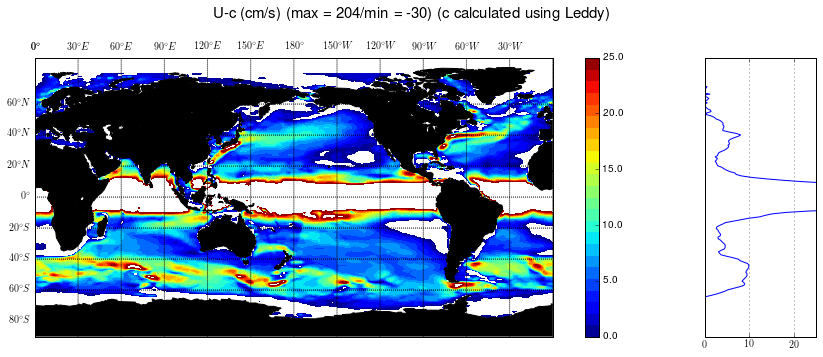

In [9]:
# <!-- collapse=True --> 
if False:
    clevs=-np.logspace(3,-3,20)
    norm=matplotlib.colors.SymLogNorm(linthresh=1e-4, vmin=-1000, vmax=-.001)
    fig,ax,cbar=MapContourg(targ_def0,c,
                    addzonal=True,
                    levels1=clevs,
                    norm=norm,
                    figsize=(14,5),
                    title="eddy phase speed c = beta*leddy**2 (cm/s) log scale")

    # Customize y tick lables
    yticks=[-1000,-500,-200,-100,-50,-20,-10,-5,-2,-1,-.500,-.200,-.1,-.05,-.02,-.01,-.005,-.002,-.001]
    cbar.set_ticks(yticks)
    cbar.set_ticklabels(yticks)
    pylab.xlim([-200.,0.])
#ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#majorFormatter = ticker.FormatStrFormatter('%.3f')
#majorLocator   = ticker.LogLocator(base=10.0, subs=[1.0], numdecs=6, numticks=15)
#ticker.MultipleLocator(20)
#cbar.ax.yaxis.set_major_locator(majorLocator)
#cbar.ax.yaxis.set_major_formatter(majorFormatter)
#ax.yaxis.get_major_formatter().set_powerlimits((0, 1))




uminusc=umean10_nearest-c  #units cm/s
clevs=np.linspace(0,25,25)
fig,ax,cbar=MapContourg(targ_def0,uminusc,
                    addzonal=True,
#                    norm=norm,
                    levels1=clevs,
                    figsize=(14,5),
                    title="U-c (cm/s) (max = %i/min = %i) (c calculated using Leddy)"%(uminusc.max(),uminusc.min()))
yticks=linspace(0,25,6)
zonalticks=np.linspace(0,20,3)
cbar.set_ticks(yticks)
cbar.set_ticklabels(yticks)
pylab.xlim([0,25])
pylab.xticks(zonalticks);

###${(U-c)}$ ( Using $c = max(- \beta * L_r^2,-20)$  )

(384, 320)
(384, 320)
(192, 289)


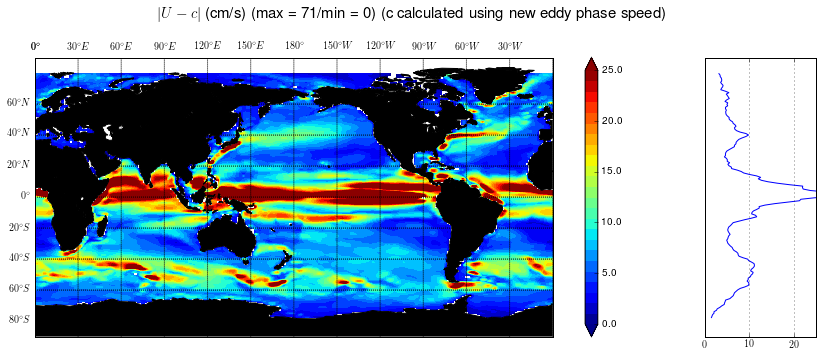

In [10]:
# <!-- collapse=True --> 
uminusc2 = nc.variables['U_MINUS_C'][0,0,:,:]
print uminusc2.shape
print orig_def.lats.shape
print targ_def0.lats.shape
uminusc2_nearest = pyresample.kd_tree.resample_nearest(orig_def, uminusc2, \
        targ_def0, radius_of_influence=500000, fill_value=None)
###uminusc2_mps=uminusc2_nearest*1.e-4

if False:
    clevs=np.linspace(-75,75,50)
    fig,ax,cbar=MapContourg(targ_def0,uminusc2_nearest,
                    addzonal=True,
#                    norm=norm,
                    levels1=clevs,
                    figsize=(14,5),
                    setover='darkred',
                    setunder='darkblue',
                    title="$|U-c|$ (cm/s) (max = %i/min = %i) (c calculated using new eddy phase speed)"%(uminusc2_nearest.max(),uminusc2_nearest.min()))
    yticks=linspace(-75,75,6)
    zonalticks=np.linspace(-25,25,3)
    cbar.set_ticks(yticks)
    cbar.set_ticklabels(yticks)
    pylab.xlim([-5,25])
    pylab.xticks(zonalticks);


clevs=np.linspace(0,25,25)
fig,ax,cbar=MapContourg(targ_def0,uminusc2_nearest,
                    addzonal=True,
#                    norm=norm,
                    levels1=clevs,
                    figsize=(14,5),
                    setover='darkred',
                    setunder='darkblue',
                    title="$|U-c|$ (cm/s) (max = %i/min = %i) (c calculated using new eddy phase speed)"%(uminusc2_nearest.max(),uminusc2_nearest.min()))
yticks=linspace(0,25,6)
zonalticks=np.linspace(0,20,3)
cbar.set_ticks(yticks)
cbar.set_ticklabels(yticks)
pylab.xlim([0,25])
pylab.xticks(zonalticks);

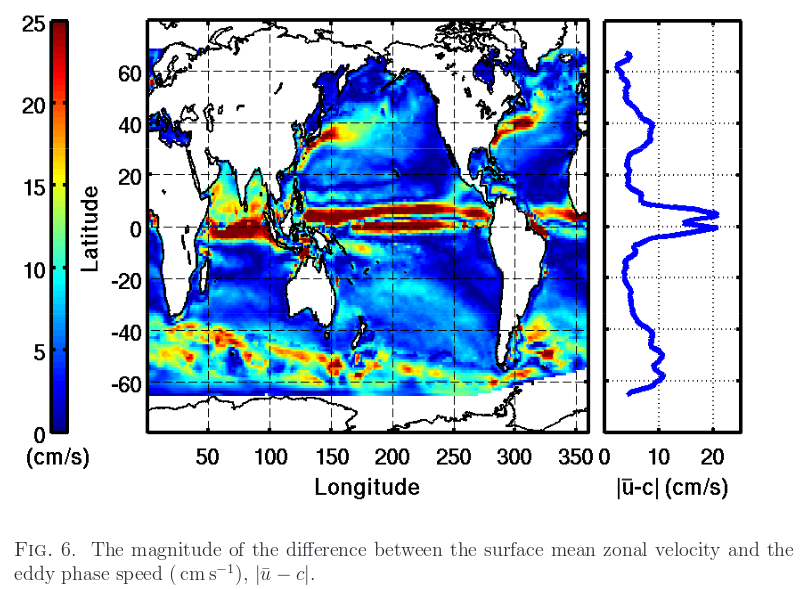

In [11]:
# <!-- collapse=True --> 
bates_uminusc=Image(filename=basedir+'/steering/bates2013_uminusc.png')
display(bates_uminusc)


###$(U-c)^2$ CESM vs Bates et al

###$\quad\quad$ First Calculating $(U-c)^2$  ($c = - \beta * L_r^2$)  

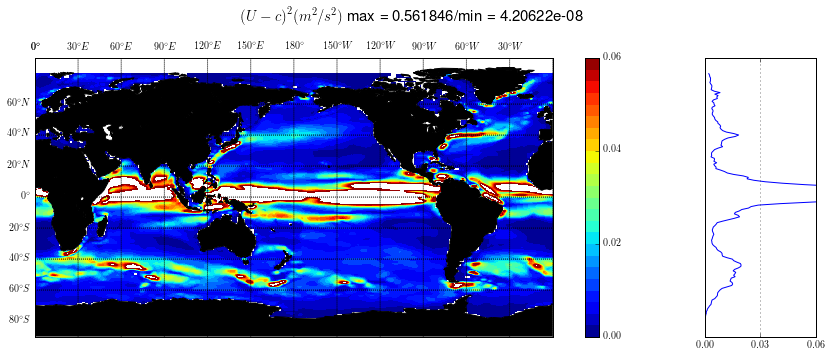

In [12]:
# <!-- collapse=True --> 
###uminusc_mps_sq=uminusc*uminusc*1.e-4   #units cm/s*cm/s*m/100cm*m/100cm
###clevs=np.logspace(-4,1,40)
###norm=LogNorm()
###fig,ax,cbar=MapContourg(lon_targcyc,lat_targcyc,uminusc_mps_sq,
###                    addzonal=True,
###                    levels1=clevs,
###                    figsize=(14,5),
###                    norm=norm,
###                    title=" ${(U-c)}^2 {(m^2/s^2)}$ max = %g/min = %g (log scale) "%(uminusc_mps_sq.max(),uminusc_mps_sq.min()))
####customize colorbar ticks
###yticks=[1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1,3,10]
###cbar.set_ticks(yticks)
####customize zonal ticks
###pylab.xlim([0,2])
###pylab.xticks([0,1,2]);
uminuscsq = nc.variables['U_MINUS_C_SQ'][0,0,:,:]
uminuscsq_nearest = pyresample.kd_tree.resample_nearest(orig_def, uminuscsq, \
        targ_def0, radius_of_influence=500000, fill_value=None)
uminuscsq_mps=uminuscsq_nearest*1.e-4

clevs=np.linspace(0,.06,25)
fig,ax,cbar=MapContourg(targ_def0,uminuscsq_mps,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title=" ${(U-c)}^2 {(m^2/s^2)}$ max = %g/min = %g "%(uminuscsq_mps.max(),uminuscsq_mps.min()))
#customize colorbar ticks
yticks=[0,.02,.04,.06]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.06])
pylab.xticks([0,.03,.06]);

uminusc_calc_sq_mps=uminusc*uminusc*1.e-4
if False:
    clevs=np.linspace(0,.06,25)
    fig,ax,cbar=MapContourg(targ_def0,uminusc_calc_sq_mps,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title=" ${(U-c)}^2 {(m^2/s^2)}$ calc max = %g/min = %g "%(uminusc2_calc_sq_mps.max(),uminusc2_calc_sq_mps.min()))
    #customize colorbar ticks
    yticks=[0,.02,.04,.06]
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.06])
    pylab.xticks([0,.03,.06]);


###$\quad\quad (U-c)^2$ using the new c_eddy field ($c = max(- \beta * L_r^2,-20)$  )

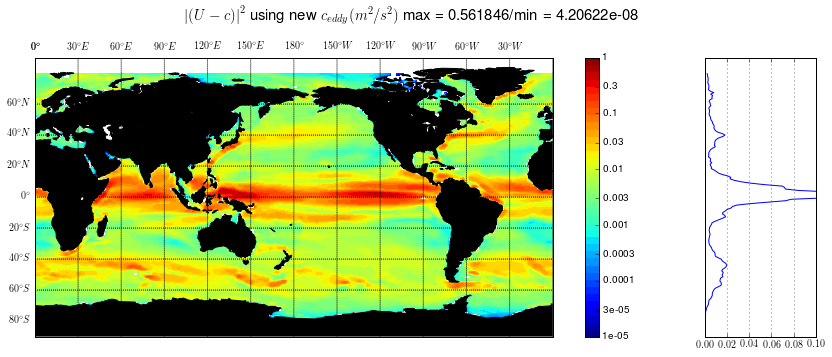

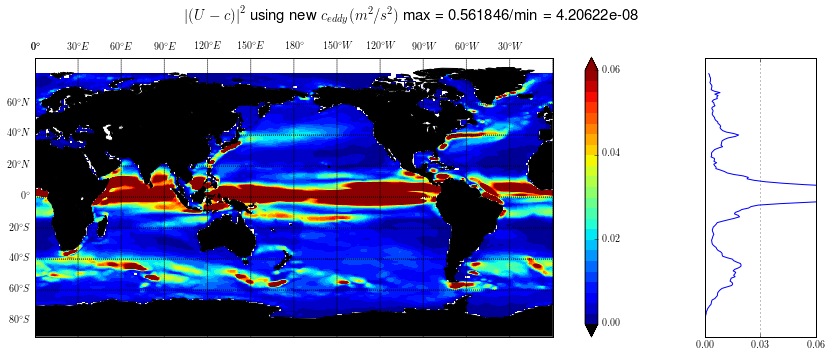

In [13]:
# <!-- collapse=True --> 

uminusc2sq = nc.variables['U_MINUS_C_SQ'][0,0,:,:]
uminusc2sq_nearest = pyresample.kd_tree.resample_nearest(orig_def, uminusc2sq, \
        targ_def0, radius_of_influence=500000, fill_value=None)
uminusc2sq_mps=uminusc2sq_nearest*1.e-4

if True:
    clevs=np.logspace(-5,0,40)
#    norm=matplotlib.colors.SymLogNorm(linthresh=1e-4, vmin=-1000, vmax=-.001)
    norm=LogNorm()
    fig,ax,cbar=MapContourg(targ_def0,uminusc2sq_mps,
                    addzonal=True,
                    levels1=clevs,
                    norm=norm,
                    figsize=(14,5),
                    title=" ${|(U-c)|}^2$ using new $c_{eddy} {(m^2/s^2)}$ max = %g/min = %g "%(uminusc2sq_mps.max(),uminusc2sq_mps.min()))

    # Customize y tick lables
    yticks=[1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1]
    cbar.set_ticks(yticks)
    cbar.set_ticklabels(yticks)
    pylab.xlim([0.,.1])

clevs=np.linspace(0,.06,25)
fig,ax,cbar=MapContourg(targ_def0,uminusc2sq_mps,
                    addzonal=True,
                    levels1=clevs,
                    setover='darkred',
                    setunder='black',
                    figsize=(14,5),
                    title=" ${|(U-c)|}^2$ using new $c_{eddy} {(m^2/s^2)}$ max = %g/min = %g "%(uminusc2sq_mps.max(),uminusc2sq_mps.min()))
#customize colorbar ticks
yticks=[0,.02,.04,.06]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.06])
pylab.xticks([0,.03,.06]);


uminusc2_calc_sq_mps=uminusc2*uminusc2*1.e-4
if False:
    clevs=np.linspace(0,.06,25)
    fig,ax,cbar=MapContourg(targ_def0,uminusc2_calc_sq_mps,
                    addzonal=True,
                    levels1=clevs,
                    setover='darkred',
                    setunder='black',
                    figsize=(14,5),
                    title=" ${|(U-c)|}^2 {(m^2/s^2)}$ calc max = %g/min = %g "%(uminusc2_calc_sq_mps.max(),uminusc2_calc_sq_mps.min()))
    #customize colorbar ticks
    yticks=[0,.02,.04,.06]
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.06])
    pylab.xticks([0,.03,.06]);





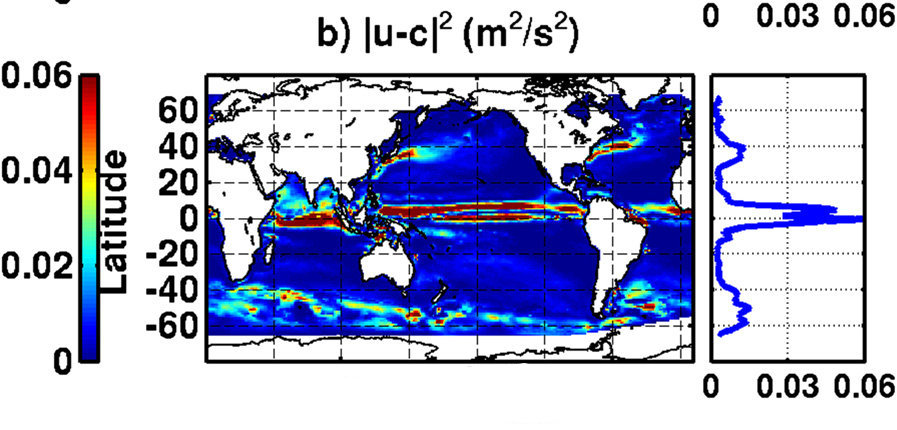

In [14]:
# <!-- collapse=True --> 
bates_uminuscsq=Image(filename=basedir+'/steering/Bates_u_minus_c_sq.jpg')
display(bates_uminuscsq)


###Parameterizing the root-mean-square eddy velocity $\color{red}{u_{rms}}$ and the Eady Growth Rate $\color{red}{\sigma_{vi}}$

$K=\color{red}{u_{rms}}∗{\Gamma * L_{eddy} \over (1 + b1 * |u_{mean} - c|^2 /u_{rms}^2 (z=0)} $

$u_{rms} = alpha*\color{red}{\sigma_{vi}}*L_{eddy}$ 

###The original derivation of $\sigma_{vi}$:

$\sigma_{vi} = {f \over \sqrt{R_i}}$

with $R_i$ the vertically integrated (over the 100 – 2000 m depth range) Richardson number.


###An alternate derivation of $\sigma_{vi}$ is:
<script type="text/x-mathjax-config">
  MathJax.Hub.Config({
    extensions: ["tex2jax.js"],
    jax: ["input/TeX", "output/HTML-CSS"],
    tex2jax: {
      inlineMath: [ ['$','$'], ["\\(","\\)"] ],
      displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
      processEscapes: true
    },
    "HTML-CSS": {scale: 100}
  });
</script>
<script type="text/javascript" src="path-to-MathJax/MathJax.js">
</script>


$ R_i = {N^2 \over {  ( \frac {\partial u}{\partial z} )^2 +  ( \frac {\partial v}{\partial z} )^2}  }$

$ N^2 = {{-g \over \rho_0 }\frac {\partial \rho}{\partial z}} $

After hydrostatic and geostrophic approximations

$f \frac {\partial v}{\partial z} =  {{-g \over \rho_0 }\frac {\partial \rho}{\partial x}}; \quad\quad f \frac {\partial u}{\partial z} =  {{g \over \rho_0 }\frac {\partial \rho}{\partial y}} $

so

$\frac {\partial v}{\partial z} =  {{-1\over f}{g \over \rho_0 }\frac {\partial \rho}{\partial x}}; \quad\quad  \frac {\partial u}{\partial z} =  {{1\over f}{g \over \rho_0 }\frac {\partial \rho}{\partial y}} $

$\therefore$

$ R_i = {f^2 N^2 \over \underbrace{{ {g^2 \over \rho_0^2 } ( \frac{\partial \rho}{\partial y})^2 + {g^2 \over \rho_0^2 } ( \frac{\partial \rho}{\partial z})^2} }_\text{m^4}}\quad\quad = \quad\quad {f^2N^2 \over m^4} $

$\sigma_{vi} = {f \over \sqrt{R_i}}\quad = \quad {f \over \sqrt{{f^2N^2 \over m^4}}}\quad = \quad {{\cancel f m^2} \over \cancel f N}$

$RX_1 = RX_{east} = \Delta\rho_x = \rho_{i+1,j} - \rho_{i,j}$

$RY_1 = RY_{north} = \Delta\rho_y = \rho_{i,j+1} - \rho_{i,j}$

$RZ_1 = RZ_{k+1} = \Delta\rho_z = \rho_{k} - \rho_{k+1}$

$\displaystyle{1 \over L_{R_i}} \displaystyle\int_{2000m}^{100m} \left\lbrace { {-g\over\rho_0}{\frac {\partial \rho} {\partial z}} \over 
{ {g^2 \over \rho_0^2 } \left[( \frac{\partial \rho}{\partial y})^2 + ( \frac{\partial \rho}{\partial z})^2\right] } } \right\rbrace dz$

Note: missing $f^2$ which will be cancelled when forming $\sigma_{vi}$ 

$\quad\quad$ so $\cdots$ this is not $R_i$


### Implementation notes

Numerator : Top $= -grav * RZ_{SAVE}(\cdots k+1) * dzwr(k)$


Denominator : 


$
\begin{align}
work1 = p25 & * ( RX(..,i_{east},k)^2 \\
& + RX(..,i_{west},k)^2 \\
& + RX(..,i_{east},k+1)^2 \\
& + RX(..,i_{west},k+1)^2 ) / DXT(i,j)^2 \\
\end{align}
$

$
\begin{align}
work2 = p25 & * ( RY(..,j_{north},k)^2 \\
& + RY(..,j_{south},k)^2 \\
& + RY(..,j_{north},k+1)^2 \\
& + RY(..,j_{south},k+1)^2  / DYT(i,j)^2 \\
\end{align}
$

$work3 = {\left( TOP \over (grav^2*(work1+work2))\right)}*dzw(k)$

Notes:

    1)Need to be careful at top and bottom of ocean
    2)Accurate dzw(k) for each (i,j) to form $L_{R_i}$
    3) When constructing $sigma$ itself, use $RZ_{SAVE}$ with a minimum N value
    4) use eps2

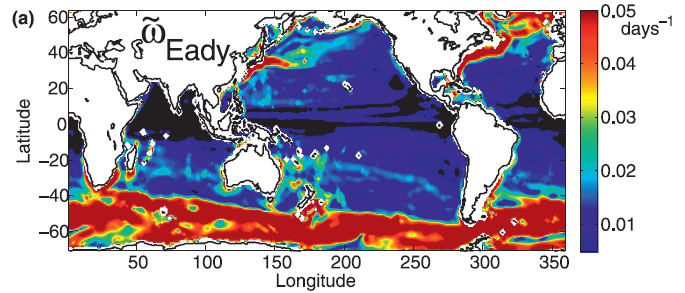

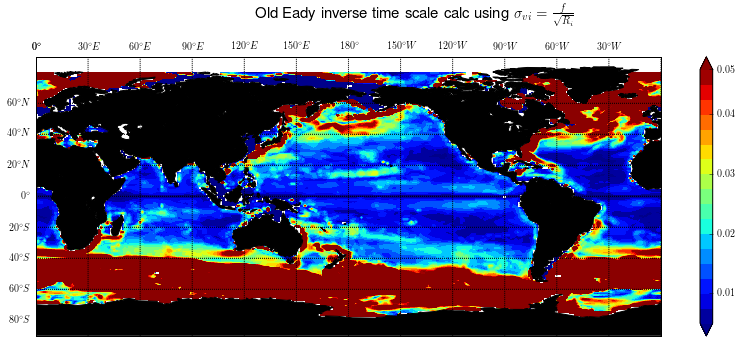

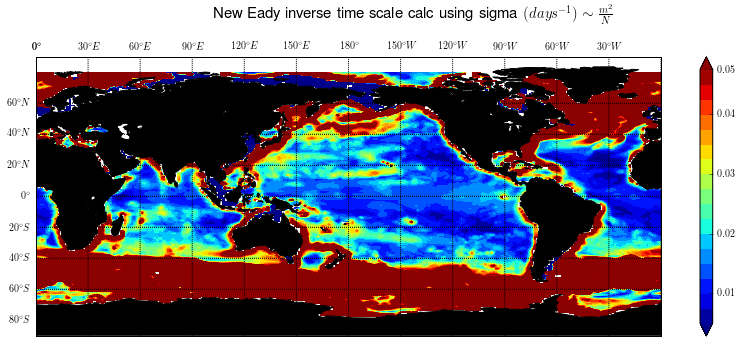

In [15]:
# <!-- collapse=True --> 
sigma_old = nc.variables['SIGMA_AVG'][0,:,:]
sigma_old_nearest = pyresample.kd_tree.resample_nearest(orig_def, sigma_old, \
        targ_def0, radius_of_influence=500000, fill_value=None)

sigma_avg1 = nc.variables['SIGMA_AVG1'][0,:,:]
sigma_avg1_nearest = pyresample.kd_tree.resample_nearest(orig_def, sigma_avg1, \
        targ_def0, radius_of_influence=500000, fill_value=None)

clevs=arange(.005,.05,.0025)
fig,ax,cbar=MapContourg(targ_def0,sigma_old_nearest*86400,
                levels1=clevs,
                figsize=(14,5),
                setunder='darkblue',
                setover='darkred',
                title="Old Eady inverse time scale calc using ${\sigma_{vi} = {f \over \sqrt{R_i}}}$")
yticks=[.01,.02,.03,.04,.05]
cbar.set_ticks(yticks)



clevs=arange(.005,.05,.0025)
fig,ax,cbar=MapContourg(targ_def0,sigma_avg1_nearest*86400,
                levels1=clevs,
                figsize=(14,5),
                setunder='darkblue',
                setover='darkred',
                title="New Eady inverse time scale calc using sigma $(days^{-1}) \sim  {{m^2} \over N}$")
yticks=[.01,.02,.03,.04,.05]
cbar.set_ticks(yticks)

tulloch_eady=Image(filename=basedir+'/steering/tulloch_eady.png')
display(tulloch_eady)

###$u_{rms} = alpha * \sigma_{new} * l_{eddy} (alpha=4) \quad$ CESM vs Bates

$u_{rms}$ is limited to 5cm/s  $ \quad max(u_{rms},5.)$

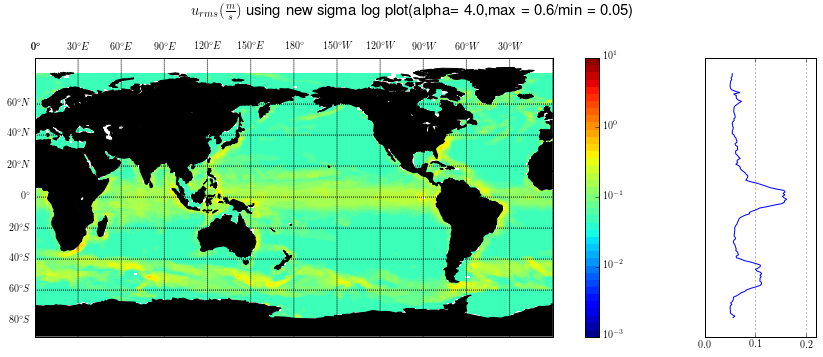

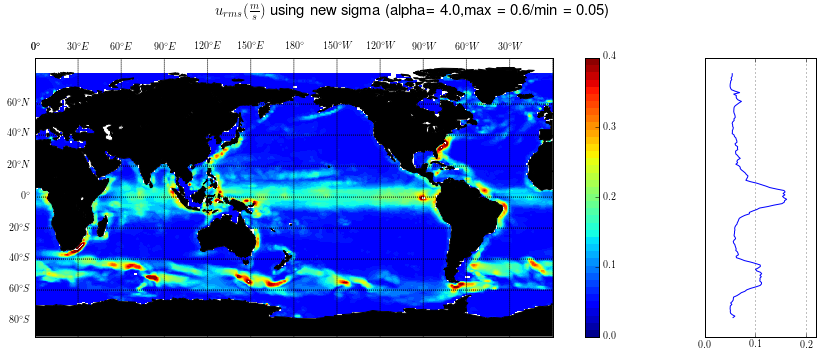

In [16]:
# <!-- collapse=True --> 
alpha=4
cm2m=.01
#
urms_avg  =  nc.variables['URMS_AVG'][0,:,:]
urms_avg_nearest = pyresample.kd_tree.resample_nearest(orig_def, urms_avg, 
        targ_def0, radius_of_influence=500000, fill_value=None)
urms_avg_mps=urms_avg_nearest*cm2m

if False:
    clevs=np.linspace(0,.4,40)
    fig,ax,cbar=MapContourg(targ_def0,urms_avg_mps,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title="$u_{rms} ({m \over s})$ using old sigma  (alpha=4,max = %.1f/min = %.1f) "%(urms_avg_mps.max(),urms_avg_mps.min()))
    #customize colorbar ticks
    yticks=[0,.1,.2,.3,.4]
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.22])
    pylab.xticks([0,.1,.2]);


urms_avg1 = nc.variables['URMS_AVG1'][0,0,:,:]
urms_avg1_nearest = pyresample.kd_tree.resample_nearest(orig_def, urms_avg1, 
        targ_def0, radius_of_influence=500000, fill_value=None)
urms_avg1_mps=urms_avg1_nearest*cm2m

clevs=np.logspace(-3,1,40)
norm=LogNorm()
fig,ax,cbar=MapContourg(targ_def0,urms_avg1_mps,                
                    addzonal=True,
                    levels1=clevs,
                    norm=norm,
                    figsize=(14,5),
                    setover='darkred',
                    setunder='darkblue',
                    title="$u_{rms} ({m \over s})$ using new sigma log plot(alpha= %.1f,max = %.1f/min = %.2G) "%(alpha,urms_avg1_mps.max(),urms_avg1_mps.min()))
#customize colorbar ticks
yticks=np.logspace(-5,1,7)
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.22])
pylab.xticks([0,.1,.2]);


clevs=np.linspace(0,.4,40)
fig,ax,cbar=MapContourg(targ_def0,urms_avg1_mps,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title="$u_{rms} ({m \over s})$ using new sigma (alpha= %.1f,max = %.1f/min = %.2G) "%(alpha,urms_avg1_mps.max(),urms_avg1_mps.min()))
#customize colorbar ticks
yticks=[0,.1,.2,.3,.4]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.22])
pylab.xticks([0,.1,.2]);


cm2m=.01
l_eddy_calc_m=l_eddy_calc*cm2m
urms_calc_mps=alpha*sigma_avg1_nearest*l_eddy_calc_m
if False:
    clevs=np.linspace(0,.4,40)
    fig,ax,cbar=MapContourg(targ_def0,urms_calc_mps,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title="$u_{rms} ({m \over s})$ calc value  (alpha= %.1f,max = %.1f/min = %.1f) "%(alpha,urms_calc_mps.max(),urms_calc_mps.min()))
    #customize colorbar ticks
    yticks=[0,.1,.2,.3,.4]
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.22])
    pylab.xticks([0,.1,.2]);


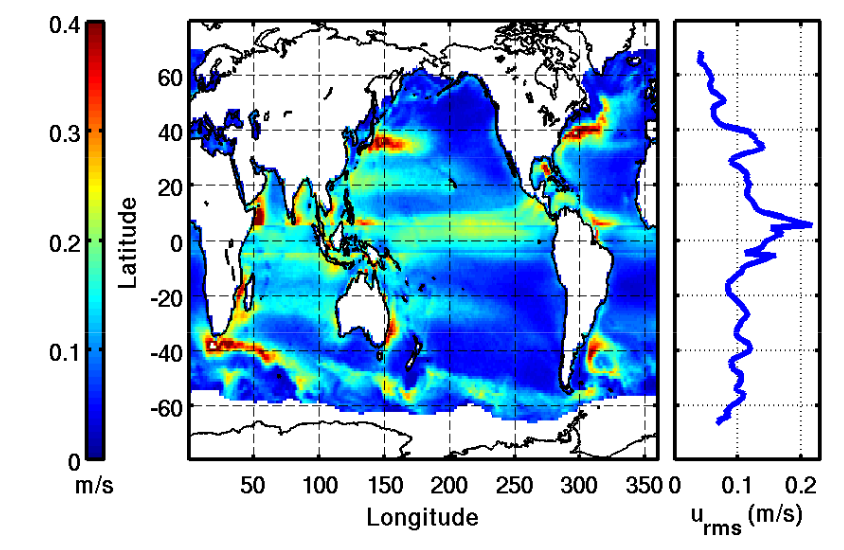

In [17]:
# <!-- collapse=True --> 
bates_urms=Image(filename=basedir+'/steering/bates2013-urms.png')
display(bates_urms)


###$u_{rms}^2  \quad$ CESM vs Bates

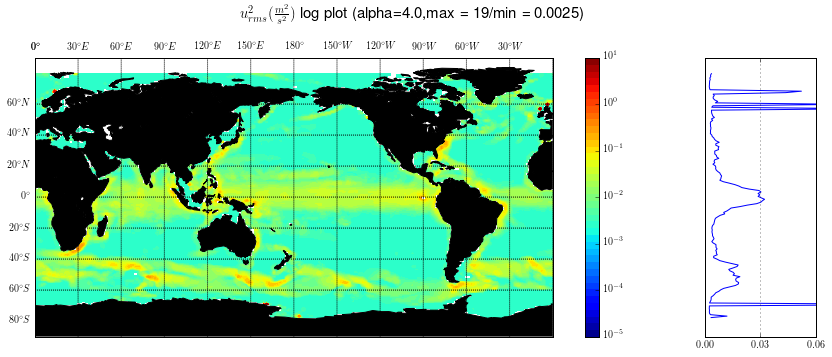

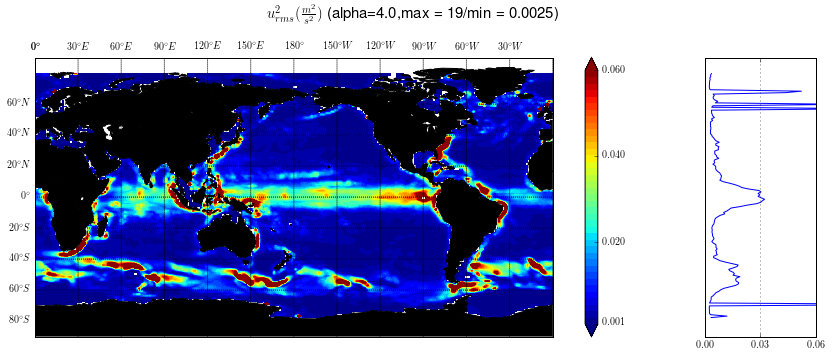

In [18]:
#### <!-- collapse=True --> 
urms_avg1_sq = nc.variables['URMS_AVG1_SQ'][0,0,:,:]
urms_avg1_sq_nearest = pyresample.kd_tree.resample_nearest(orig_def, urms_avg1_sq, 
        targ_def0, radius_of_influence=500000, fill_value=None)
urms_avg1_sq_mps=urms_avg1_sq_nearest*1.e-4
###urms_avg1_sq_mps =urms_avg1_mps*urms_avg1_mps

if True:
    clevs=np.logspace(-5,1,42)
    norm=LogNorm()
    fig,ax,cbar=MapContourg(targ_def0,urms_avg1_sq_mps,                
                    addzonal=True,
                    levels1=clevs,
                    norm=norm,
                    figsize=(14,5),
                    setover='darkred',
                    setunder='darkblue',
                    title="$u_{rms}^2 ({m^2 \over s^2})$ log plot (alpha=%.1f,max = %.2G/min = %.2G) "%(alpha,urms_avg1_sq_mps.max(),urms_avg1_sq_mps.min()))
    #customize colorbar ticks
    yticks=np.logspace(-5,1,7)
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.06])
    pylab.xticks([0,.03,.06]);



##clevs=np.linspace(0,.06,40)
clevs=np.linspace(.001,.06,40)
fig,ax,cbar=MapContourg(targ_def0,urms_avg1_sq_mps,
                    addzonal=True,
                    levels1=clevs,
                    setover='darkred',
                    setunder='darkblue',
                    figsize=(14,5),
                    title="$u_{rms}^2 ({m^2 \over s^2})$ (alpha=%.1f,max = %.2G/min = %.2G) "%(alpha,urms_avg1_sq_mps.max(),urms_avg1_sq_mps.min()))
#customize colorbar ticks
yticks=[.001,.02,.04,.06]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.06])
pylab.xticks([0,.03,.06]);

urms_calc_mps_sq=urms_calc_mps*urms_calc_mps

if False:
    clevs=np.linspace(.001,.06,40)
    fig,ax,cbar=MapContourg(targ_def0,urms_calc_mps_sq,
                    addzonal=True,
                    levels1=clevs,
                    setover='darkred',
                    setunder='darkblue',
                    figsize=(14,5),
                    title="$u_{rms}^2 ({m^2 \over s^2})$ (alpha=%.1f,max = %.2G/min = %.2G) "%(alpha,urms_calc_mps_sq.max(),urms_calc_mps_sq.min()))
    #customize colorbar ticks
    yticks=[.001,.02,.04,.06]
    cbar.set_ticks(yticks)
    #customize zonal ticks
    pylab.xlim([0,.06])
    pylab.xticks([0,.03,.06]);


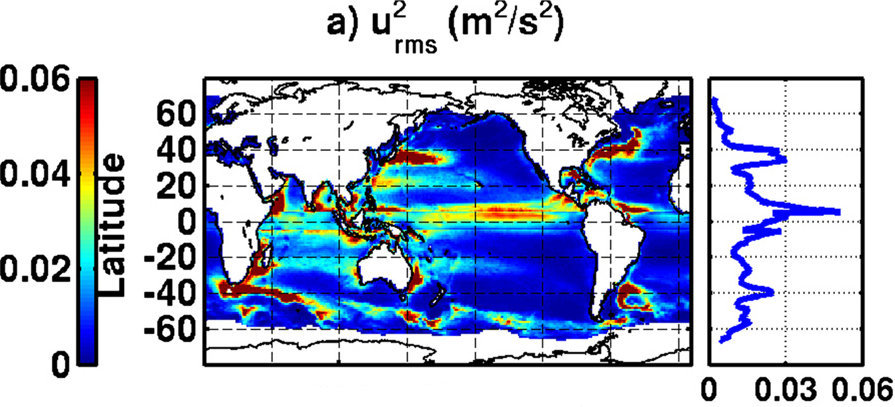

In [19]:
# <!-- collapse=True --> 
urms_bates=Image(filename=basedir+'/steering/Bates_urms_sq.jpg')
display(urms_bates)


###${(U-c)}^2 \over u_{rms}^2   \quad$ CESM vs Bates

Using $c = max(- \beta * L_r^2,-20)$ and  $u_{rms} = max(u_{rms},5.)$

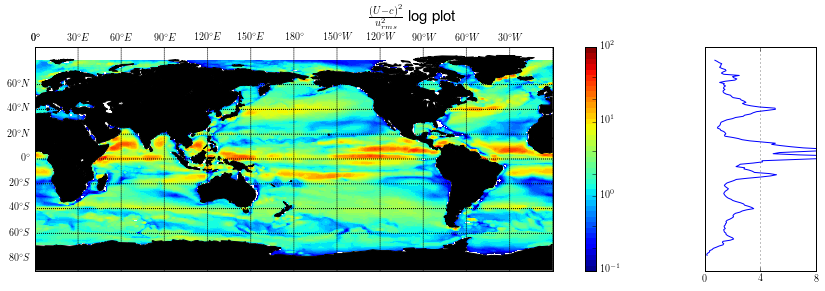

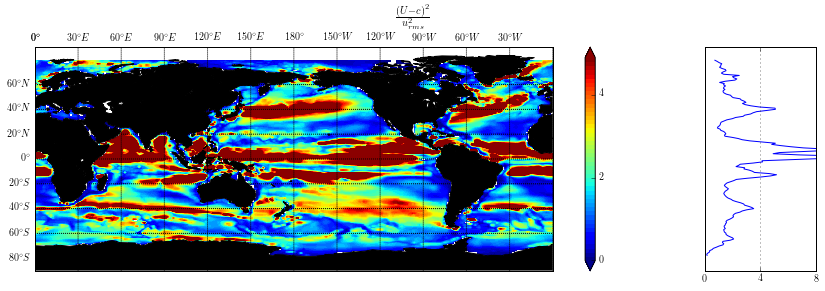

In [20]:
# <!-- collapse=True --> 
umc2ourms2 = nc.variables['UMCSQ_OVR_URMSSQ'][0,0,:,:]
umc2ourms2_nearest = pyresample.kd_tree.resample_nearest(orig_def,umc2ourms2 , 
        targ_def0, radius_of_influence=500000, fill_value=None)

clevs=np.logspace(-1,2,42)
norm=LogNorm()
fig,ax,cbar=MapContourg(targ_def0,umc2ourms2_nearest,                
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,4),
                    norm=norm,
                    setover='darkred',
                    setunder='darkblue',
                    title="${(U-c)}^2 \over u_{rms}^2$ log plot")
#customize colorbar ticks
#yticks=clevs=np.logspace(-1,2,10)
yticks=[1e-1,2e-1,4e-1,1,2,4,1e1,2e1,4e1,10e1]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,8])
pylab.xticks([0,4,8]);


clevs=arange(0,5,.1)
fig,ax,cbar=MapContourg(targ_def0,umc2ourms2_nearest,                
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,4),
                    setover='darkred',
                    setunder='darkblue',
                    title="${(U-c)}^2 \over u_{rms}^2$")
#customize colorbar ticks
yticks=[0,2,4]
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,8])
pylab.xticks([0,4,8]);


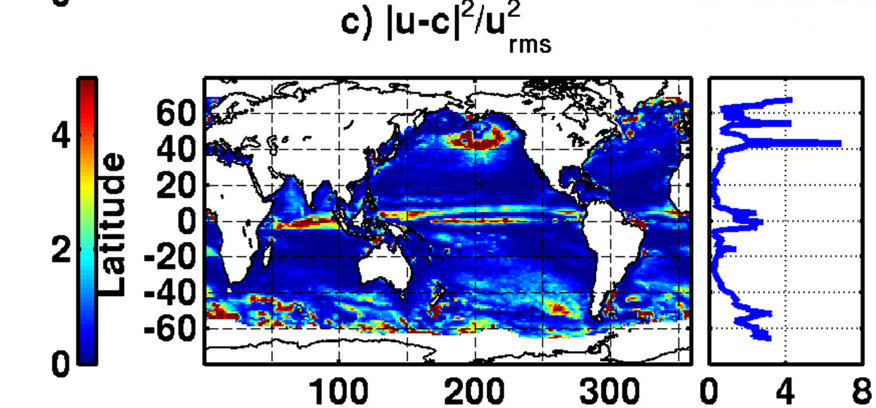

In [21]:
# <!-- collapse=True --> 
bates_uminusc_sq_ovr_urms_sq =Image(filename=basedir+'/steering/Bates_suppress.jpg')
display(bates_uminusc_sq_ovr_urms_sq )


### Suppression factor $= {1 \over (1 + b1 * |\bar u - c|^2 /u_{rms (z=0)}^2 )}$ 

(Adjustment to U_rms helps the suppression everywhere except N/S of 50 degrees.)

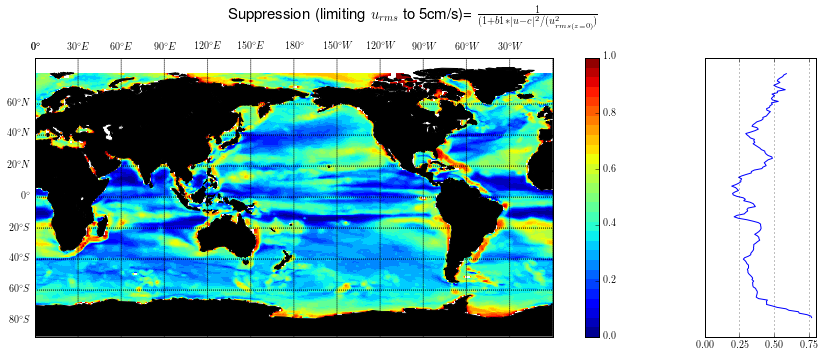

In [22]:
# <!-- collapse=True --> 
supp = nc.variables['SUPP'][0,0,:,:]
supp_nearest = pyresample.kd_tree.resample_nearest(orig_def,supp , 
        targ_def0, radius_of_influence=500000, fill_value=None)

clevs=np.linspace(0,1,30)
norm=matplotlib.colors.Normalize()
fig,ax,cbar=MapContourg(targ_def0,supp_nearest,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title="Suppression (limiting $u_{rms}$ to 5cm/s)= ${1 \over (1 + b1 * | u - c|^2 /(u_{rms (z=0)}^2)}$ ")
#customize colorbar ticks
yticks=np.linspace(0, 1, 6)
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,.8])
pylab.xticks([0,.25,.5,.75]);


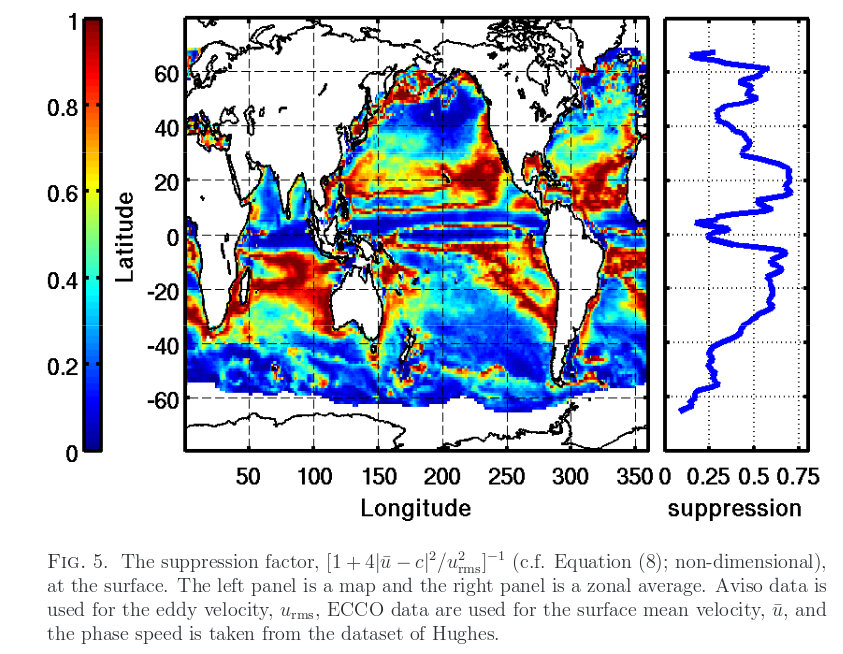

In [23]:
# <!-- collapse=True --> 
bates_suppression =Image(filename=basedir+'/steering/bates2013_suppression.png')
display(bates_suppression )


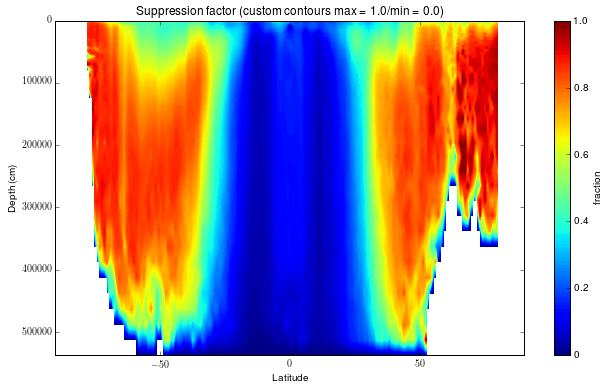

In [24]:
# <!-- collapse=True -->
clevs=np.linspace(0,1,11)

z_t= ncregrid.variables['z_t'][:]

latregrid=ncregrid.variables['lat'][:]
lonregrid=ncregrid.variables['lon'][:]
lon=lonregrid

suppregrid= ncregrid.variables['SUPP'][0,:,:,:]
suppregridz=suppregrid.mean(axis=2)
clevs=np.linspace(0,1,100,endpoint=True)
yticks=[0,.2,.4,.6,.8,1.]
fig,ax,cbar=plotzonalocn(latregrid, z_t, suppregridz,
                    levels1=clevs,
                    levels2=clevs,
#                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="Suppression factor (custom contours max = %.1f/min = %.1f) "%(suppregridz.max(),suppregridz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                                                                                                                                                                                                                              
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('fraction')                                                                                                                                                                                            


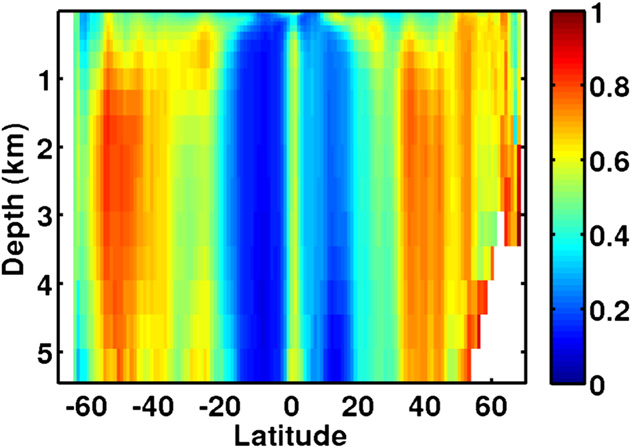

In [25]:
urms_bates7=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-007.jpg')
display(urms_bates7 )

###Parameterizing the Mixing term $\color{red}{L_{mix}}$
$\color{red}{L_{mix}} = \Gamma * L_{eddy} * Suppression$

$\Gamma = 0.35$

$b1 = 4$ 

$Suppression= {1 \over (1 + b1 * |u_{mean} - c|^2 /u_{rms (z=0)}^2 )}$

$\color{red}{L_{mix}} = {\Gamma * L_{eddy} \over (1 + b1 * |u_{mean} - c|^2 /u_{rms}^2 (z=0)}$

###LMIX
    1.new c fixes values around equator
    2.latest urms average using m^2/n implementation of sigma

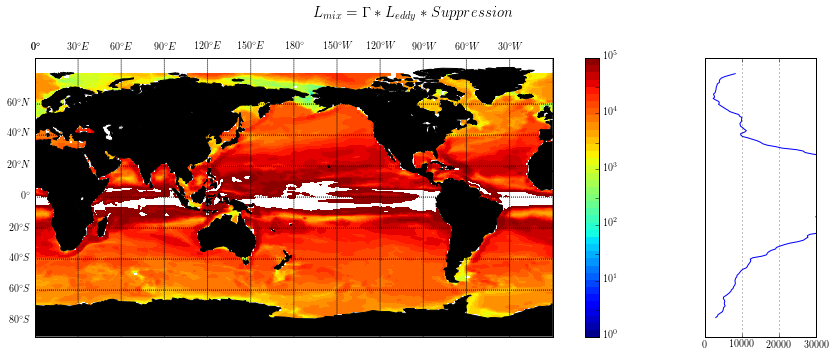

In [26]:
# <!-- collapse=True -->
lmix2 = nc.variables['LMIX'][0,0,:,:]
lmix2_nearest = pyresample.kd_tree.resample_nearest(orig_def,lmix2*cm2m , 
        targ_def0, radius_of_influence=500000, fill_value=None)

norm=LogNorm()
clevs=np.logspace(0,5,40)
fig,ax,cbar=MapContourg(targ_def0,lmix2_nearest,
                    addzonal=True,
                    norm=norm,
                    levels1=clevs,
                    figsize=(14,5),
                    title="$L_{mix} = {\Gamma * L_{eddy} * Suppression} $")
cbar.set_ticks([1,3,1e1,3e1,1e2,3e2,1e3,3e3,1e4,3e4,1e5])
#customize zonal ticks
##pylab.xlim([0,10e3])
##pylab.xticks([0,2500,5000,7500,10000]);
pylab.xlim([0,30e3])
##pylab.xticks([0,2500,5000,7500,10000]);
pylab.xticks([0,10000,20000,30000]);

###Parameterizing Eddy diffusivity $\color{red}{K}$
###$\color{red}{K}=u_{rms}∗L_{mix}$

Shown are 

$K$ 

$K_{lim}$ using a supression field with $u_{rms}^2$ limited to 100.  

They both look very similar but the $K_{lim}$ does add more suppression (albeit small) outside of 20 lat. The high maximum value of this field though still causes the model to blow up.

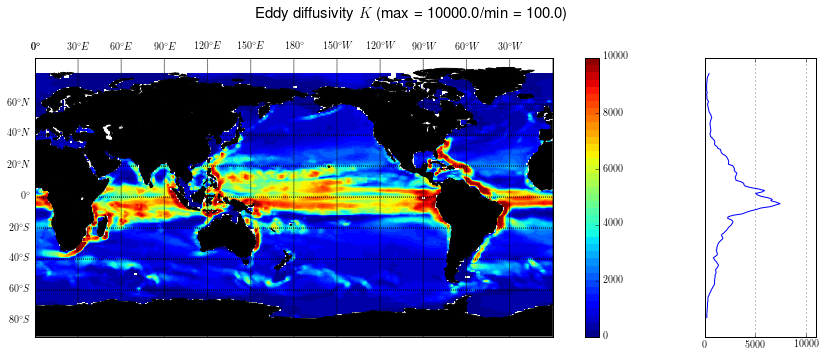

In [27]:
# <!-- collapse=True --> 
###gamma=.35
###############GAMMA bumped up for tuning #########################
gamma=1.75
b1=4.
###regrid2rect(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.017.pop.h.nday1.0249.nc',basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.017.regrid.nc',clobber=True)
###ncregrid = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.017.regrid.nc')
kvertsrf= ncregrid.variables['KVERT'][0,0,:,:]*1.e-4

clevs=np.linspace(0,1.e4,40)
fig,ax,cbar=MapContourg(targ_def0,kvertsrf,
                    addzonal=True,
                    levels1=clevs,
                    figsize=(14,5),
                    title="Eddy diffusivity $K$ (max = %.1f/min = %.1f) "%(kvertsrf.max(),kvertsrf.min()))
#customize colorbar ticks
#cbar.set_ticks([1,3,1e1,3e1,1e2,3e2,1e3,3e3,1e4,])
yticks=np.linspace(0, 10000,6)
cbar.set_ticks(yticks)
#customize zonal ticks
pylab.xlim([0,11e3])
pylab.xticks([0,5e3,10e3]);



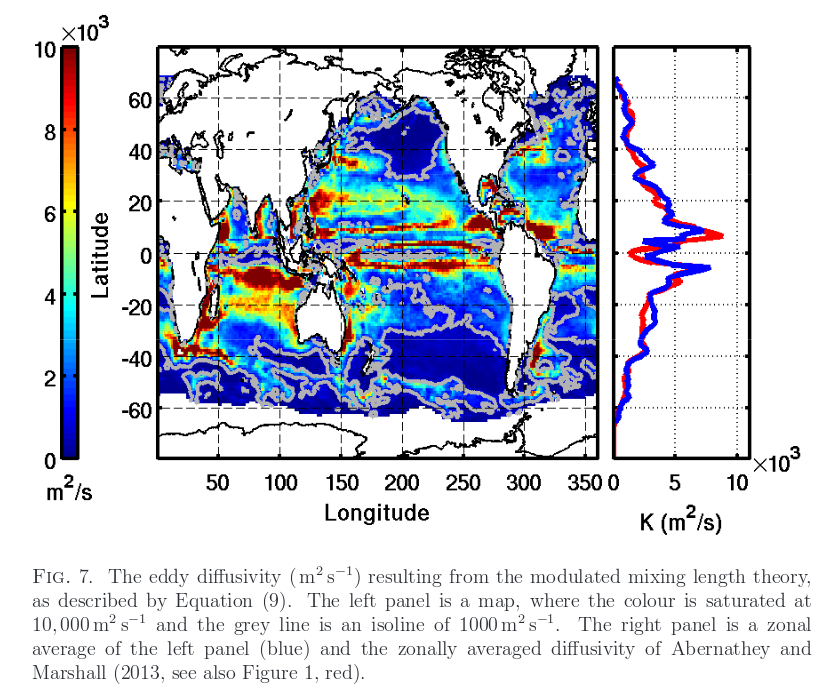

In [28]:
# <!-- collapse=True --> 
bates_k =Image(filename=basedir+'/steering/bates2013_K.png')
display(bates_k )


##Below is a zonal plot of eddy diffusivity plotted for each level using a scaled value of eddy velocity ($U_{rms_{scaled}}$)

####( overbar indicates yearly averages)



###${K}=\overline{U_{rms_{scaled}}} ∗ \overline {L_{mix}}$
#### where 

$\overline{U_{rms_{scaled}}}=\overline{U_{rms}*N2_{norm}}\quad $ and

${L_{mix}} = {\Gamma * L_{eddy} \over (1 + b1 * |u_{mean} - c|^2 /u_{rms}^2 (z=0)}$ (note $urms^2$ in the suppression term is a surface value)

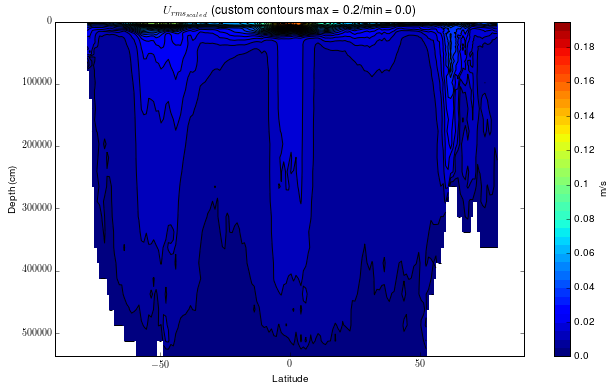

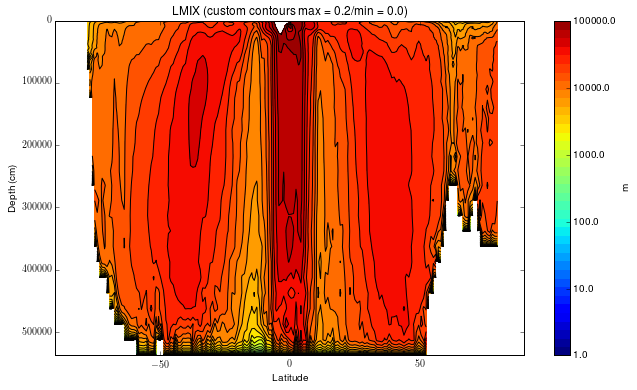

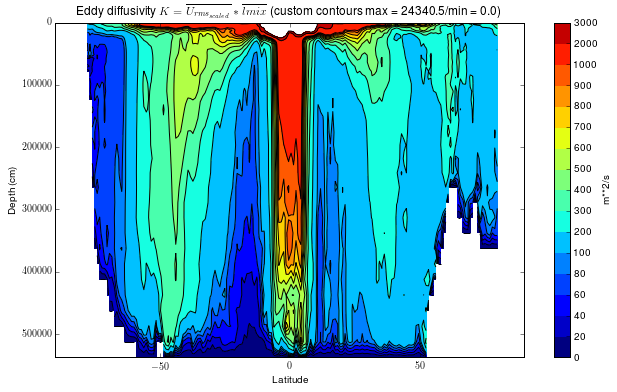

In [29]:
# <!-- collapse=True --> 
########### Plot urms_scaled ############################
###ncregrid = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.017.regrid.nc')
z_t= ncregrid.variables['z_t'][:]

latregrid=ncregrid.variables['lat'][:]
lonregrid=ncregrid.variables['lon'][:]
lon=lonregrid

urmsk = ncregrid.variables['URMS_AVG1'][0,:,:,:]
urmskz=urmsk.mean(axis=2)/1.e2
clevs=np.arange(0,.2,.005)
fig,ax,cbar=plotzonalocn(latregrid, z_t, urmskz,
                    levels1=clevs,
                    levels2=clevs,
                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="$U_{rms_{scaled}}$ (custom contours max = %.1f/min = %.1f) "%(urmskz.max(),urmskz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                     
yticks=     np.arange(0,.2,.02)                                                                                                                                                                                                   
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('m/s')                                                                                                                                                                                            
########### Plot LMIX ############################

lmixk = ncregrid.variables['LMIX'][0,:,:,:]
lmixkz=lmixk.mean(axis=2)/1.e2
clevs=np.logspace(0,5,40)
fig,ax,cbar=plotzonalocn(latregrid, z_t, lmixkz,
                    levels1=clevs,
                    levels2=clevs,
                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="LMIX (custom contours max = %.1f/min = %.1f) "%(urmskz.max(),urmskz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                     
yticks=  clevs=np.logspace(0,5,6)                                                                                                                                                                             
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('m')

########### Plot K = urms_scaled * LMIX ############################
kcalc=urmsk*lmixk
kcalcz=kcalc.mean(axis=2)/1.e4
clevs=np.arange(0,100,20)
clevs=np.append(clevs,np.arange(100,1000,100))
clevs=np.append(clevs,np.arange(1000,4000,1000))
fig,ax,cbar=plotzonalocn(latregrid, z_t, kcalcz,
                    levels1=clevs,
                    levels2=clevs,
                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="Eddy diffusivity $K=\overline {U_{rms_{scaled}}} * \overline {lmix}$ (custom contours max = %.1f/min = %.1f) "%(kcalcz.max(),kcalcz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                     
yticks=clevs                                                                                                                                                                                                          
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('m**2/s')                                                                                                                                                                                            


In [30]:
### Here is the KAPPA_VERTICAL from the model

kvert min is  1e+06
kvert max is  1e+08
kvertz min is  100.0
kvertz max is  7598.85316697
[   0   20   40   60   80  100  200  300  400  500  600  700  800  900 1000
 2000 3000]


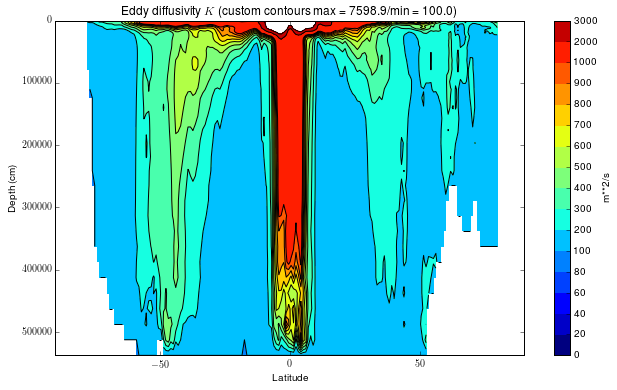

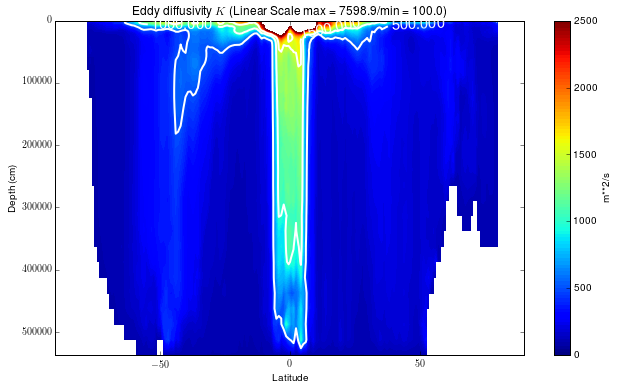

In [31]:
# <!-- collapse=True --> 

###ncregrid = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.017.regrid.nc')
z_t= ncregrid.variables['z_t'][:]

latregrid=ncregrid.variables['lat'][:]
lonregrid=ncregrid.variables['lon'][:]
lon=lonregrid

kvert= ncregrid.variables['KVERT'][0,:,:,:]
print "kvert min is ",kvert.min()
print "kvert max is ",kvert.max()
kvertz=kvert.mean(axis=2)/1.e4
print "kvertz min is ",kvertz.min()
print "kvertz max is ",kvertz.max()

clevs=np.arange(0,100,20)
clevs=np.append(clevs,np.arange(100,1000,100))
clevs=np.append(clevs,np.arange(1000,4000,1000))
print clevs                                                                                                                                                                                          
fig,ax,cbar=plotzonalocn(latregrid, z_t, kvertz,
                    levels1=clevs,
                    levels2=clevs,
                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="Eddy diffusivity $K$ (custom contours max = %.1f/min = %.1f) "%(kvertz.max(),kvertz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                     
yticks=clevs                                                                                                                                                                                                          
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('m**2/s')                                                                                                                                                                                            


clevs=np.linspace(0,2500,100,endpoint=True)
yticks=[0,500,1000,1500,2000,2500]
fig,ax,cbar=plotzonalocn(latregrid, z_t, kvertz,
                    levels1=clevs,
                    levels2=clevs,
#                    equalcontourscale=True,
                    figsize=(10.5,6),
                    title="Eddy diffusivity $K$ (Linear Scale max = %.1f/min = %.1f) "%(kvertz.max(),kvertz.min()))

# Add axis labels and plot title                            
levs=[500,1000,1500]
cs=ax.contour(latregrid, z_t, kvertz,levels=levs,colors='w',linewidths=2)
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Depth (cm)')                                                                                                                                                                                              
plt.clabel(cs, inline=1, fontsize=15)
# Customize y tick lables                                                                                                                                                                                                                                                                                                                                                                                                            
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('m**2/s')                                                                                                                                                                                            




###Here is the Bate's version

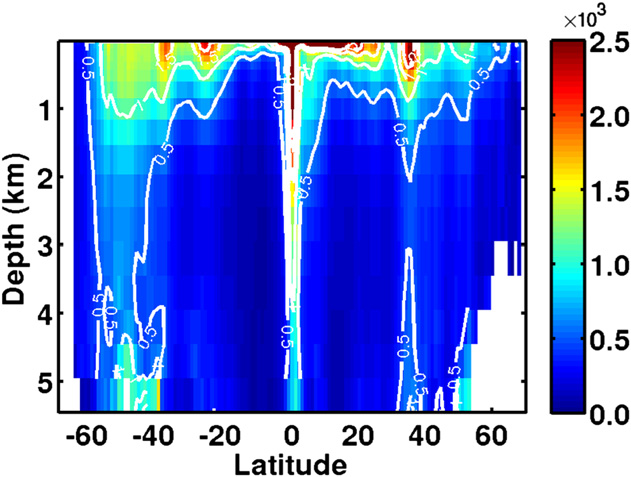

In [32]:
# <!-- collapse=True -->
urms_bates8=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-008.jpg')
display(urms_bates8)

###Zonal average of the N2 normalized scaling.

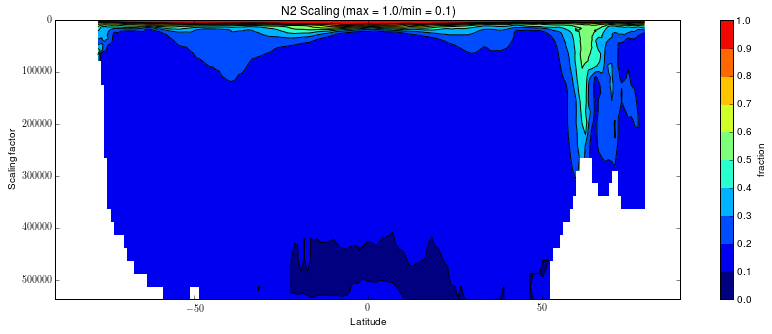

In [33]:
# <!-- collapse=True -->
clevs=np.linspace(0,1,11)
###ncregrid = Dataset(basedir+'/steering/g.e11.GIAF.T62_gx1v6.steer.015.regrid.nc')
n2norm=ncregrid.variables['BFREQ_SQ_NORM'][0,:,:,:]
n2normz=n2norm.mean(axis=2)
fig,ax,cbar=plotzonalocn(latregrid, z_t, n2normz,
                    levels1=clevs,
                    levels2=clevs,
                    equalcontourscale=True,
                    figsize=(14,5),
                    title="N2 Scaling (max = %.1f/min = %.1f) "%(n2normz.max(),n2normz.min()))

# Add axis labels and plot title                                                                                                                                                                                              
plt.xlabel('Latitude')                                                                                                                                                                                                
plt.ylabel('Scaling factor')                                                                                                                                                                                              

# Customize y tick lables                                                                                                                                                                                                     
yticks=clevs                                                                                                                                                                                                          
cbar.set_ticks(yticks)                                                                                                                                                                                                
cbar.set_ticklabels(yticks)                                                                                                                                                                                           
cbar.set_label('fraction')                                                                                                                                                                                            



###Steering Level status
    1. L_eddy values ok
    2. Rossby wave speed ok
    3. Eady inverse timescale ok
        a. Use alternate calculation otherwise has problems at equator and
        b.Richardson averages are too high causing sigma to drop too low
    4. Zonal Eddy Phase Speed (c) 
        a. Too high 10S:10N (applying an upper limit of 20cm/s helps)
        b. Missing westward velocities in ACC which appear 
            in Hughes Data
    5. (U-c) Is close if c is limited to 20cm/s
    6. U_rms  (alpha*sigma*l_eddy)  OK     
    7. Zonal mean velocity looks ok compared to ECCO annual average
    8. Suppression OK
    9. K limited (100 to 10000) is now in the ball park.


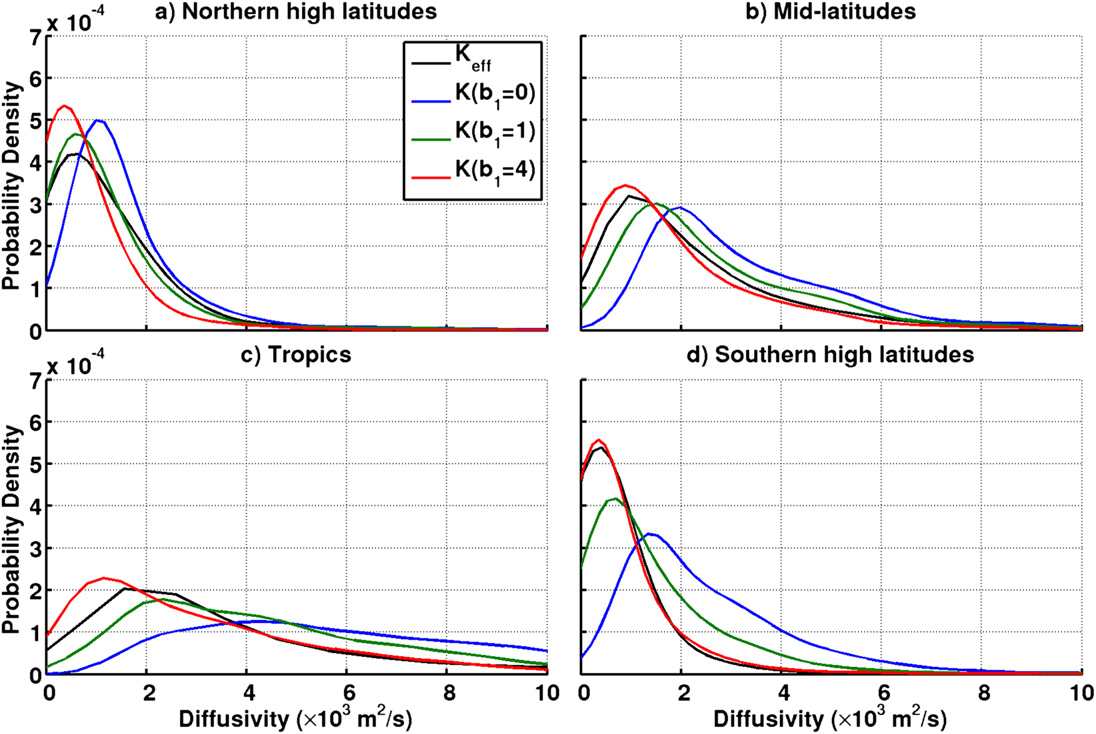

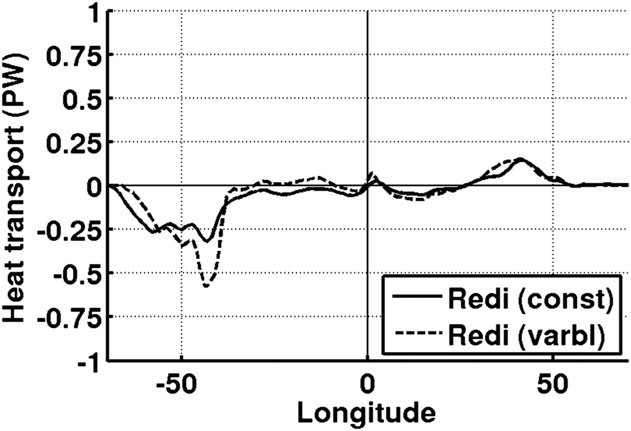

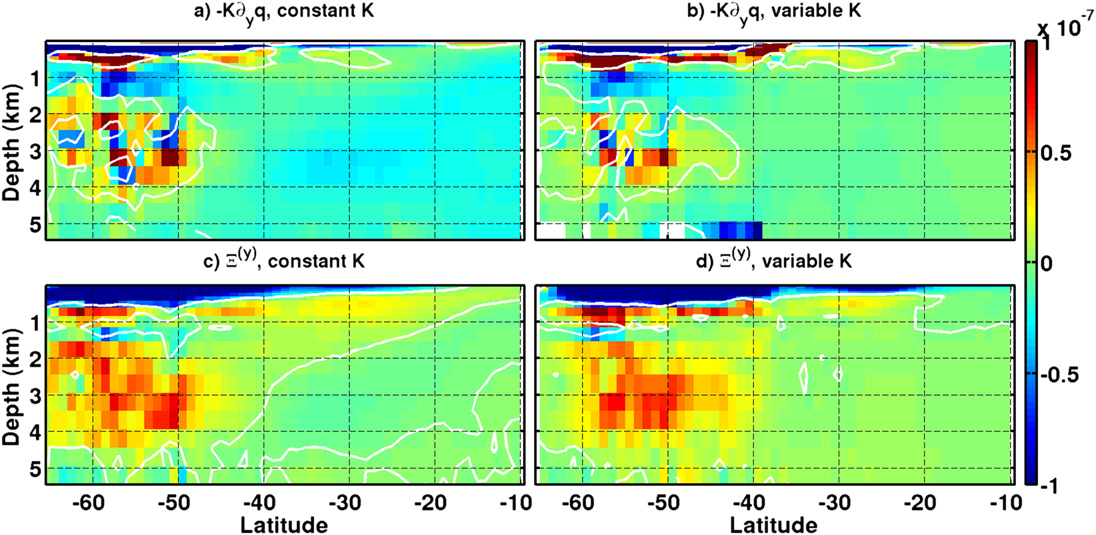

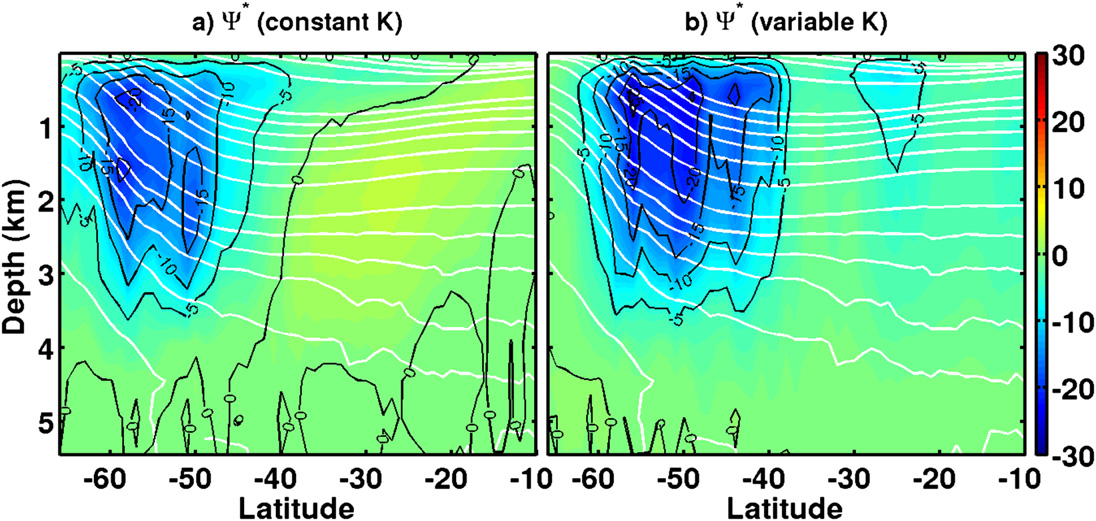

In [34]:
# <!-- collapse=True --> 
urms_bates2=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-002.jpg')
urms_bates3=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-003.jpg')
urms_bates4=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-004.jpg')
urms_bates5=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-005.jpg')
urms_bates6=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-006.jpg')
urms_bates7=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-007.jpg')
urms_bates8=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-008.jpg')
urms_bates9=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-009.jpg')
urms_bates10=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-010.jpg')
urms_bates11=Image(filename=basedir+'/steering/Bates-Tulloch-etal-2014-011.jpg')
display(urms_bates5,urms_bates9,urms_bates10,urms_bates11)


###  CESM $U_{mean} = U_{resolved}$ integraged over {10,50,100,200,500} meters

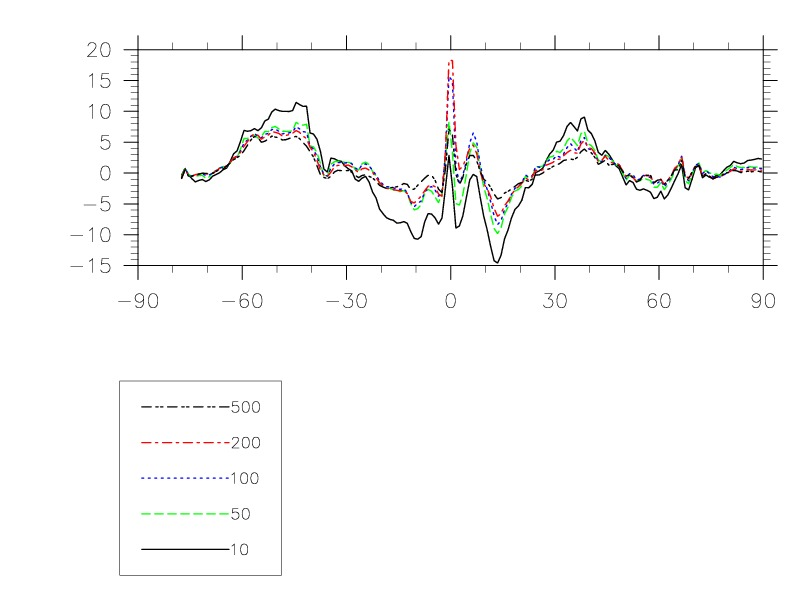

In [35]:
# <!-- collapse=True --> 
umean_cesm=Image(filename=basedir+'/steering/umean.jpg')
display(umean_cesm)

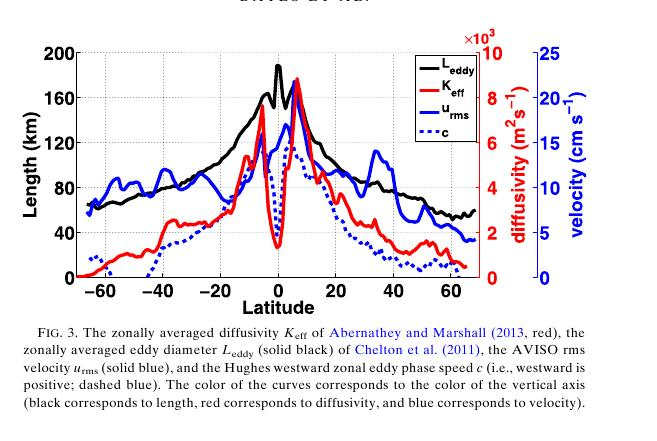

In [36]:
# <!-- collapse=True --> 
bates_len_vel=Image(filename=basedir+'/steering/bates_len_vel.jpg')
display(bates_len_vel)


In [37]:
# <!-- collapse=True --> 
from IPython import utils
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open(os.path.join(base,'profile_default/static/custom/custom.css'),'r').read())
    return HTML(styles)
css_styling()